In [214]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory|
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


Importing the libraries

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier

Loading the datasets

In [216]:
df_train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
df_test = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

Exploratory Data Analysis (EDA)

In [217]:
print(df_train.shape, df_test.shape)


(116023, 52) (29006, 51)


In [218]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [219]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

In [221]:
df_train.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


In [220]:
df_test.describe()

,date,totals.bounces,totalHits,new_visits,pageViews,totals.visits,trafficSource.adwordsClickInfo.page,sessionId,sessionNumber,sessionStart,userId,locationZone,gclIdPresent
count,2.900600e+04,11732.0,29006.000000,20094.0,29003.000000,29006.0,1107.000000,2.900600e+04,29006.000000,2.900600e+04,29006.000000,29006.0,29006.000000
mean,2.016855e+07,1.0,10.659519,1.0,8.470813,1.0,1.015357,1.493320e+09,2.595980,1.493320e+09,61327.854134,8.0,0.038268
std,6.200443e+03,0.0,19.771218,0.0,14.561705,0.0,0.177227,1.532493e+07,9.333323,1.532493e+07,35253.344987,0.0,0.191846
min,2.016080e+07,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.470035e+09,1.000000,1.470035e+09,8.000000,8.0,0.000000
25%,2.016112e+07,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.479931e+09,1.000000,1.479931e+09,31006.500000,8.0,0.000000
50%,2.017041e+07,1.0,2.000000,1.0,2.000000,1.0,1.000000,1.491492e+09,1.000000,1.491492e+09,61430.500000,8.0,0.000000
75%,2.017091e+07,1.0,12.000000,1.0,10.000000,1.0,1.000000,1.505148e+09,2.000000,1.505148e+09,91866.250000,8.0,0.000000
max,2.018043e+07,1.0,500.000000,1.0,466.000000,1.0,5.000000,1.525152e+09,334.000000,1.525152e+09,122268.000000,8.0,1.000000


In [ ]:
df_train.size

In [222]:
# Target column overview
df_train['purchaseValue'].describe()


count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

In [223]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
df_train.select_dtypes(include=['int64', 'float64']).nunique()
df_train.select_dtypes(include=['object']).nunique()

Numerical Features: ['purchaseValue', 'userId', 'gclIdPresent', 'sessionNumber', 'totals.visits', 'sessionId', 'trafficSource.adwordsClickInfo.page', 'pageViews', 'locationZone', 'totals.bounces', 'date', 'totalHits', 'sessionStart', 'new_visits']
Categorical Features: ['trafficSource.isTrueDirect', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'geoNetwork.networkLocation', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'geoNetwork.metro'

trafficSource.isTrueDirect                        1
browser                                          34
device.screenResolution                           1
trafficSource.adContent                          53
trafficSource.keyword                           566
screenSize                                        1
geoCluster                                        5
trafficSource.adwordsClickInfo.slot               3
device.mobileDeviceBranding                       1
device.mobileInputSelector                        1
trafficSource.campaign                           28
device.mobileDeviceMarketingName                  1
geoNetwork.networkDomain                          3
device.operatingSystemVersion                     1
device.flashVersion                               1
geoNetwork.region                               388
trafficSource                                   161
geoNetwork.networkLocation                        1
os                                               18
geoNetwork.s

In [225]:
df_train.dtypes.value_counts()

object     37
int64       9
float64     5
bool        1
Name: count, dtype: int64

Statistical Analysis And Visualization

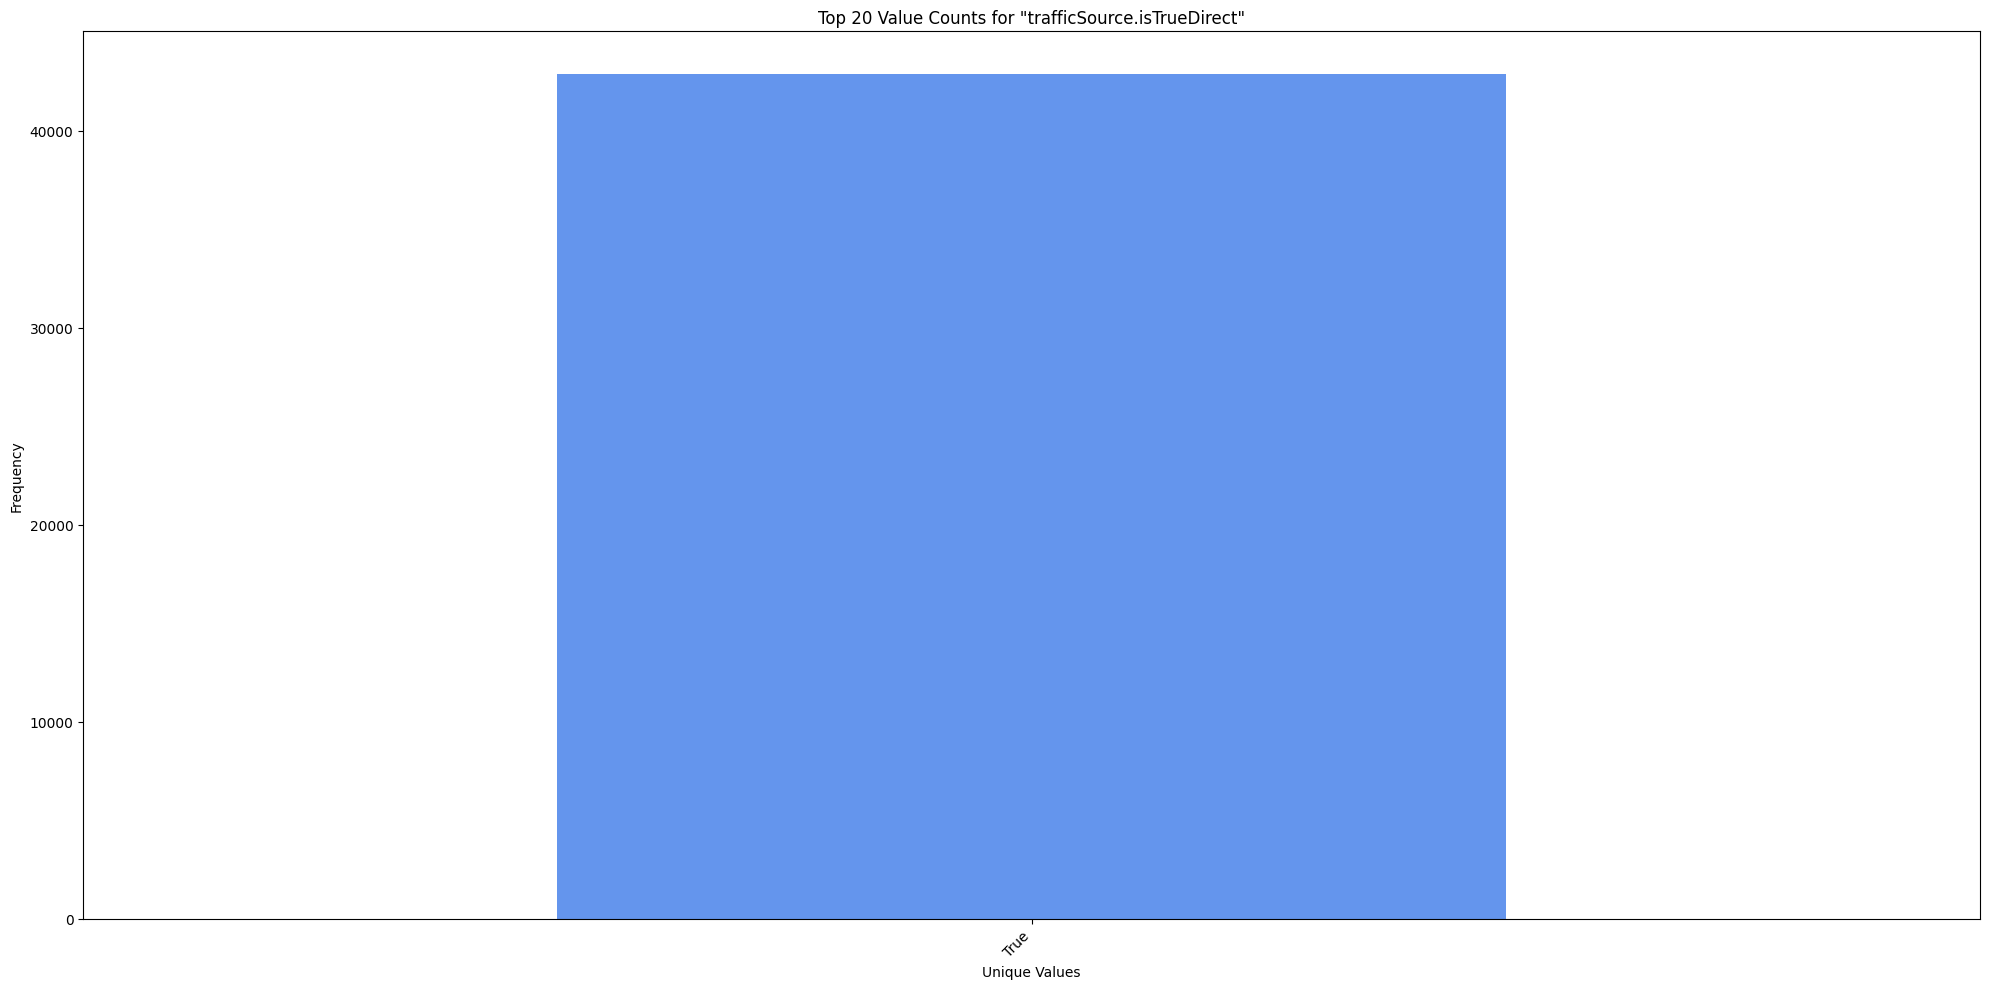

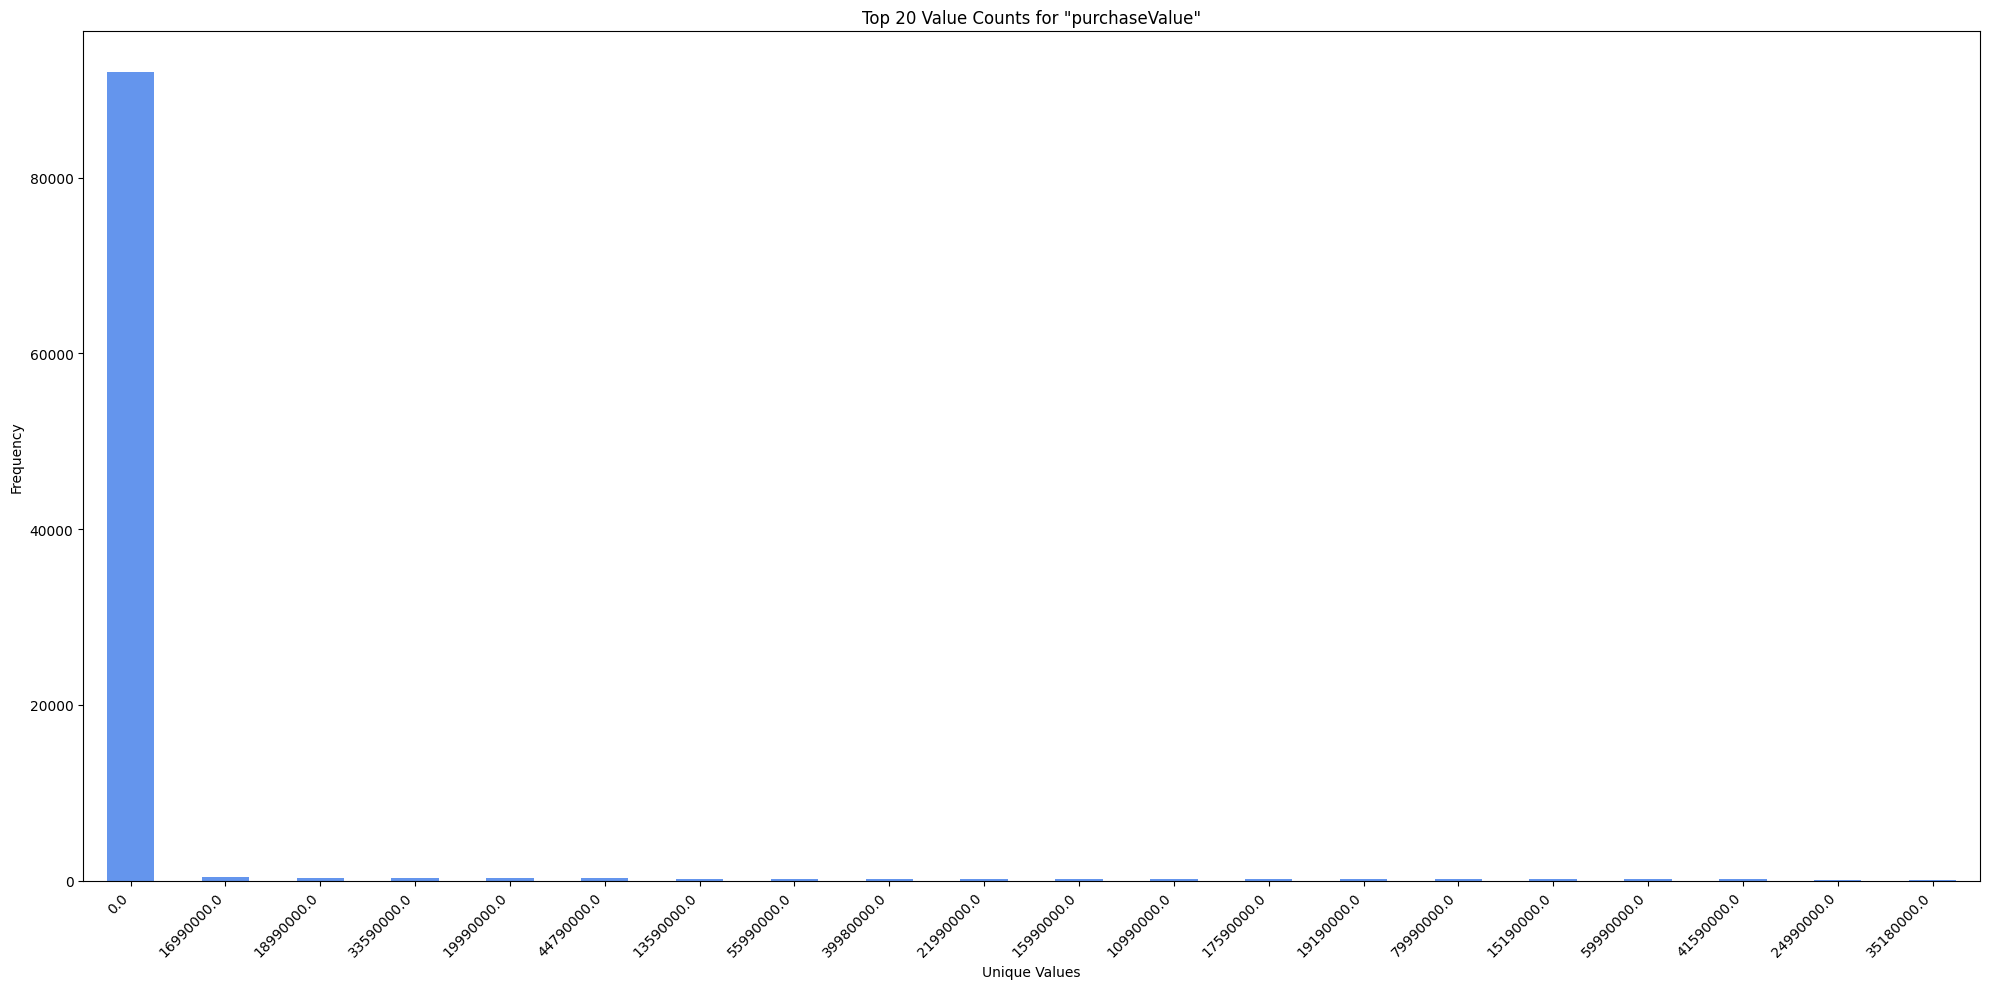

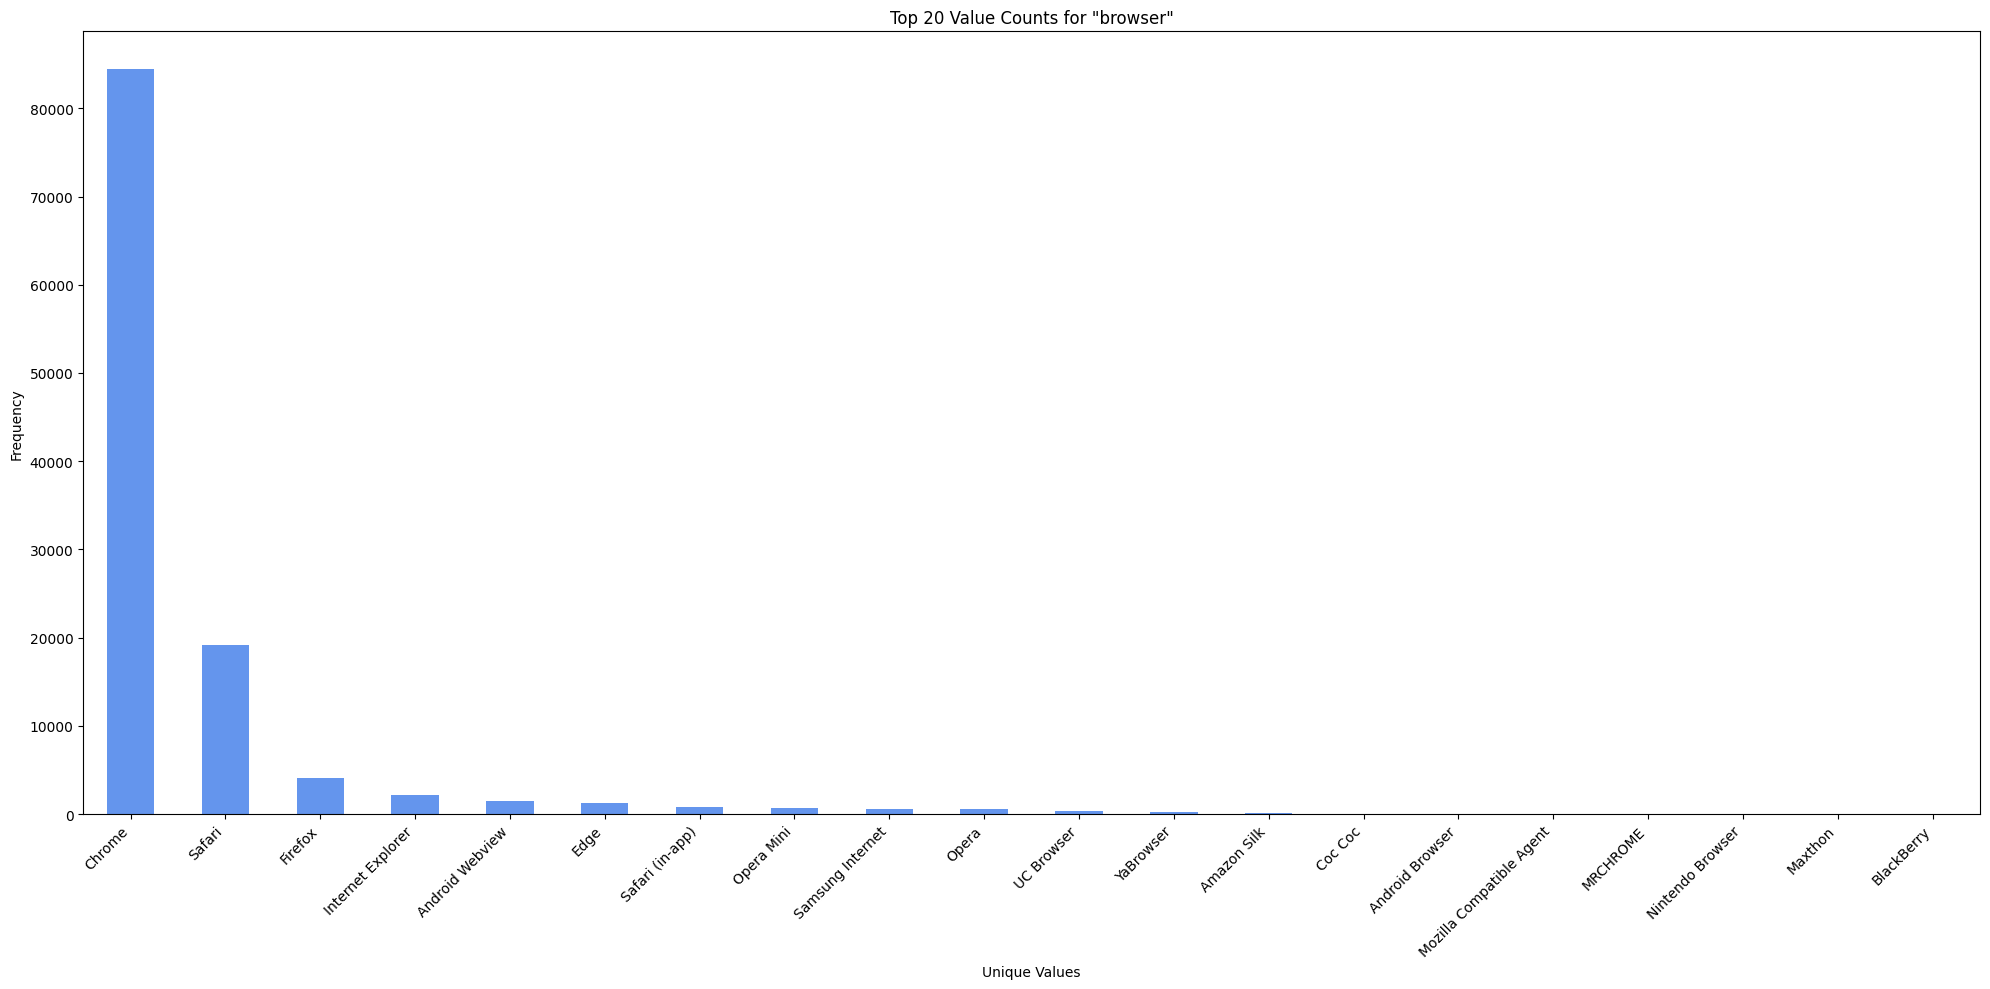

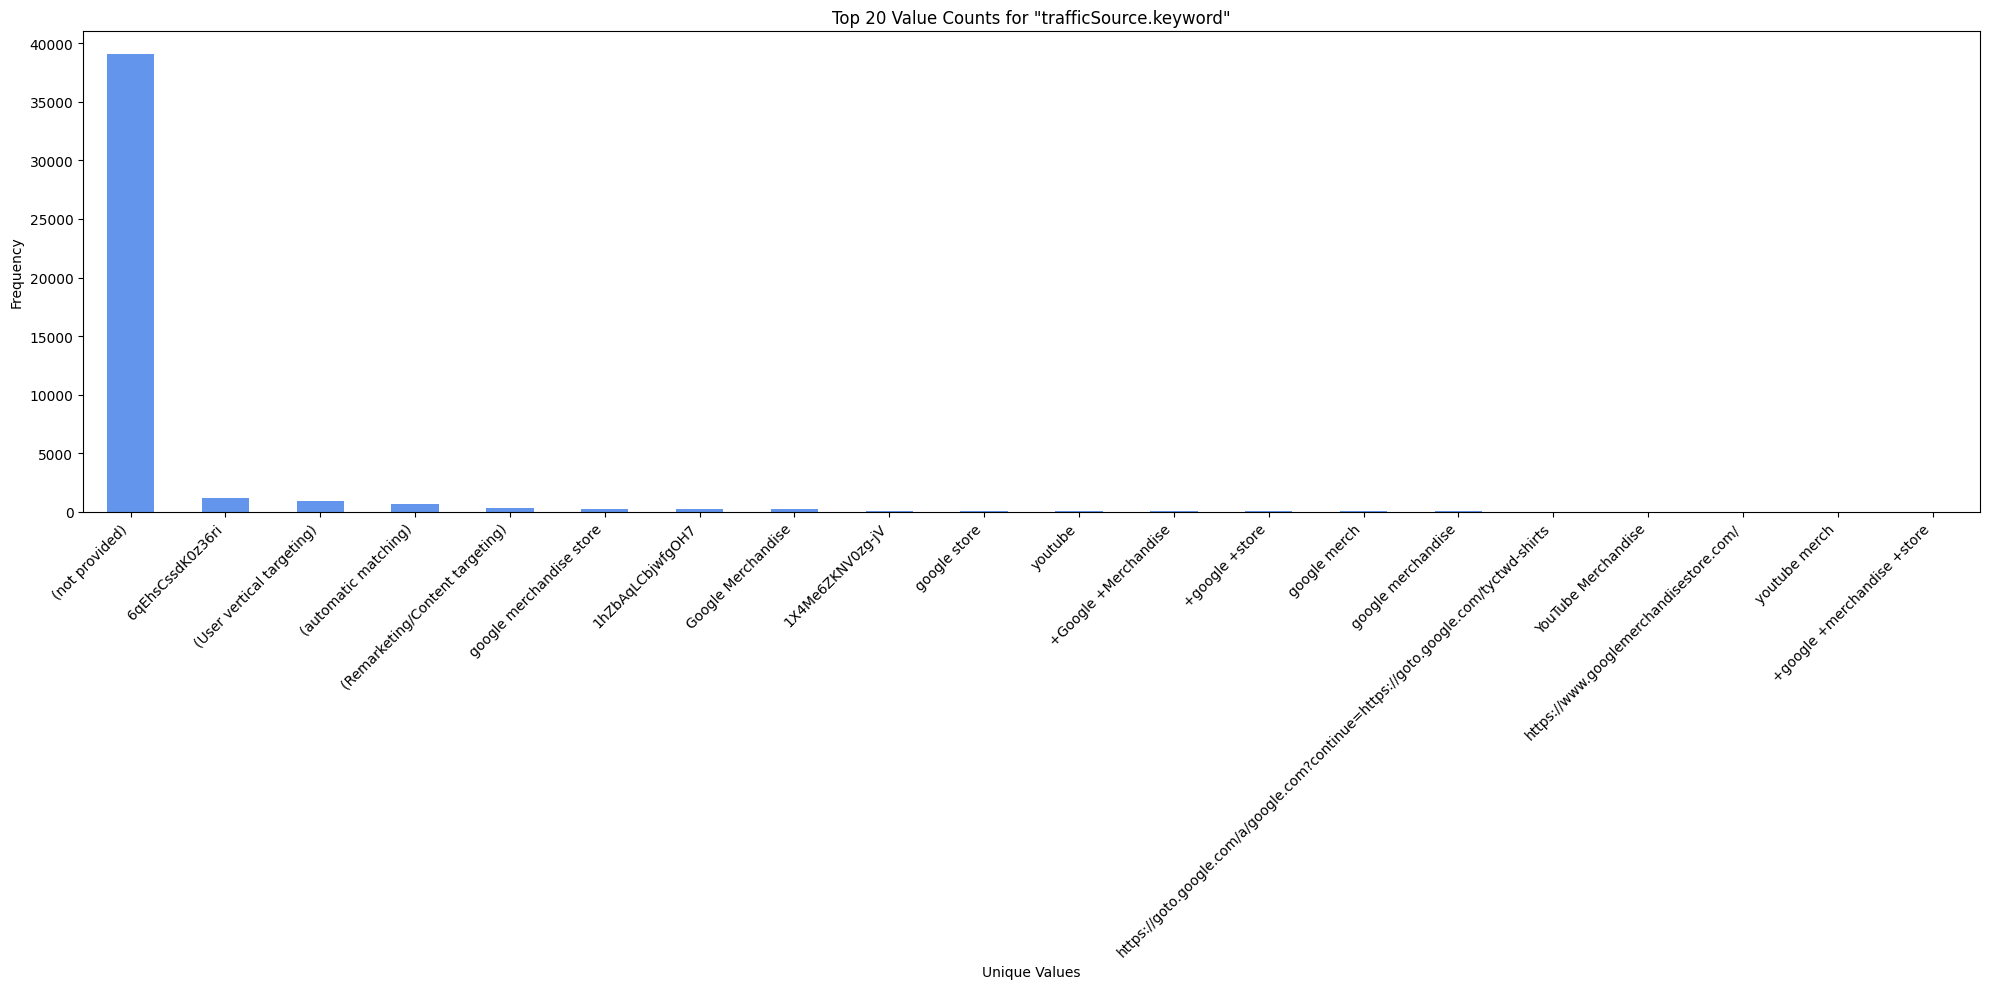

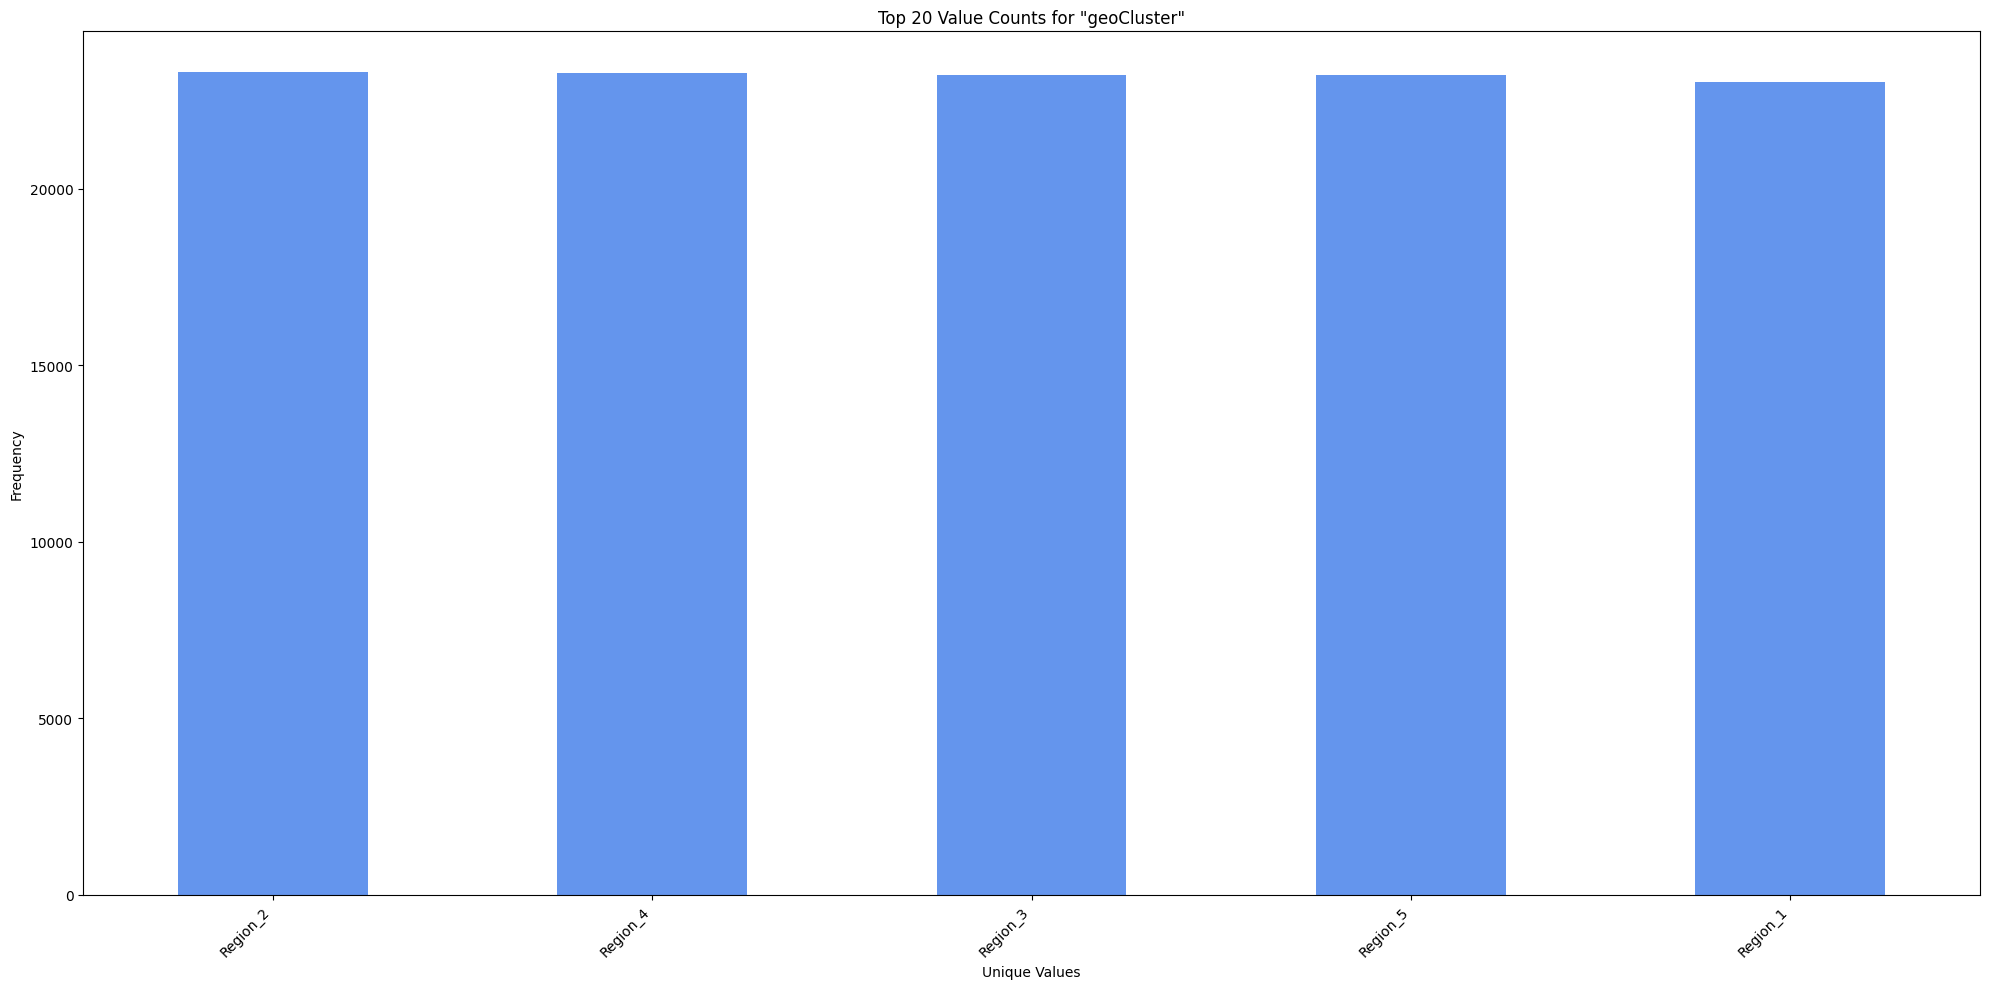

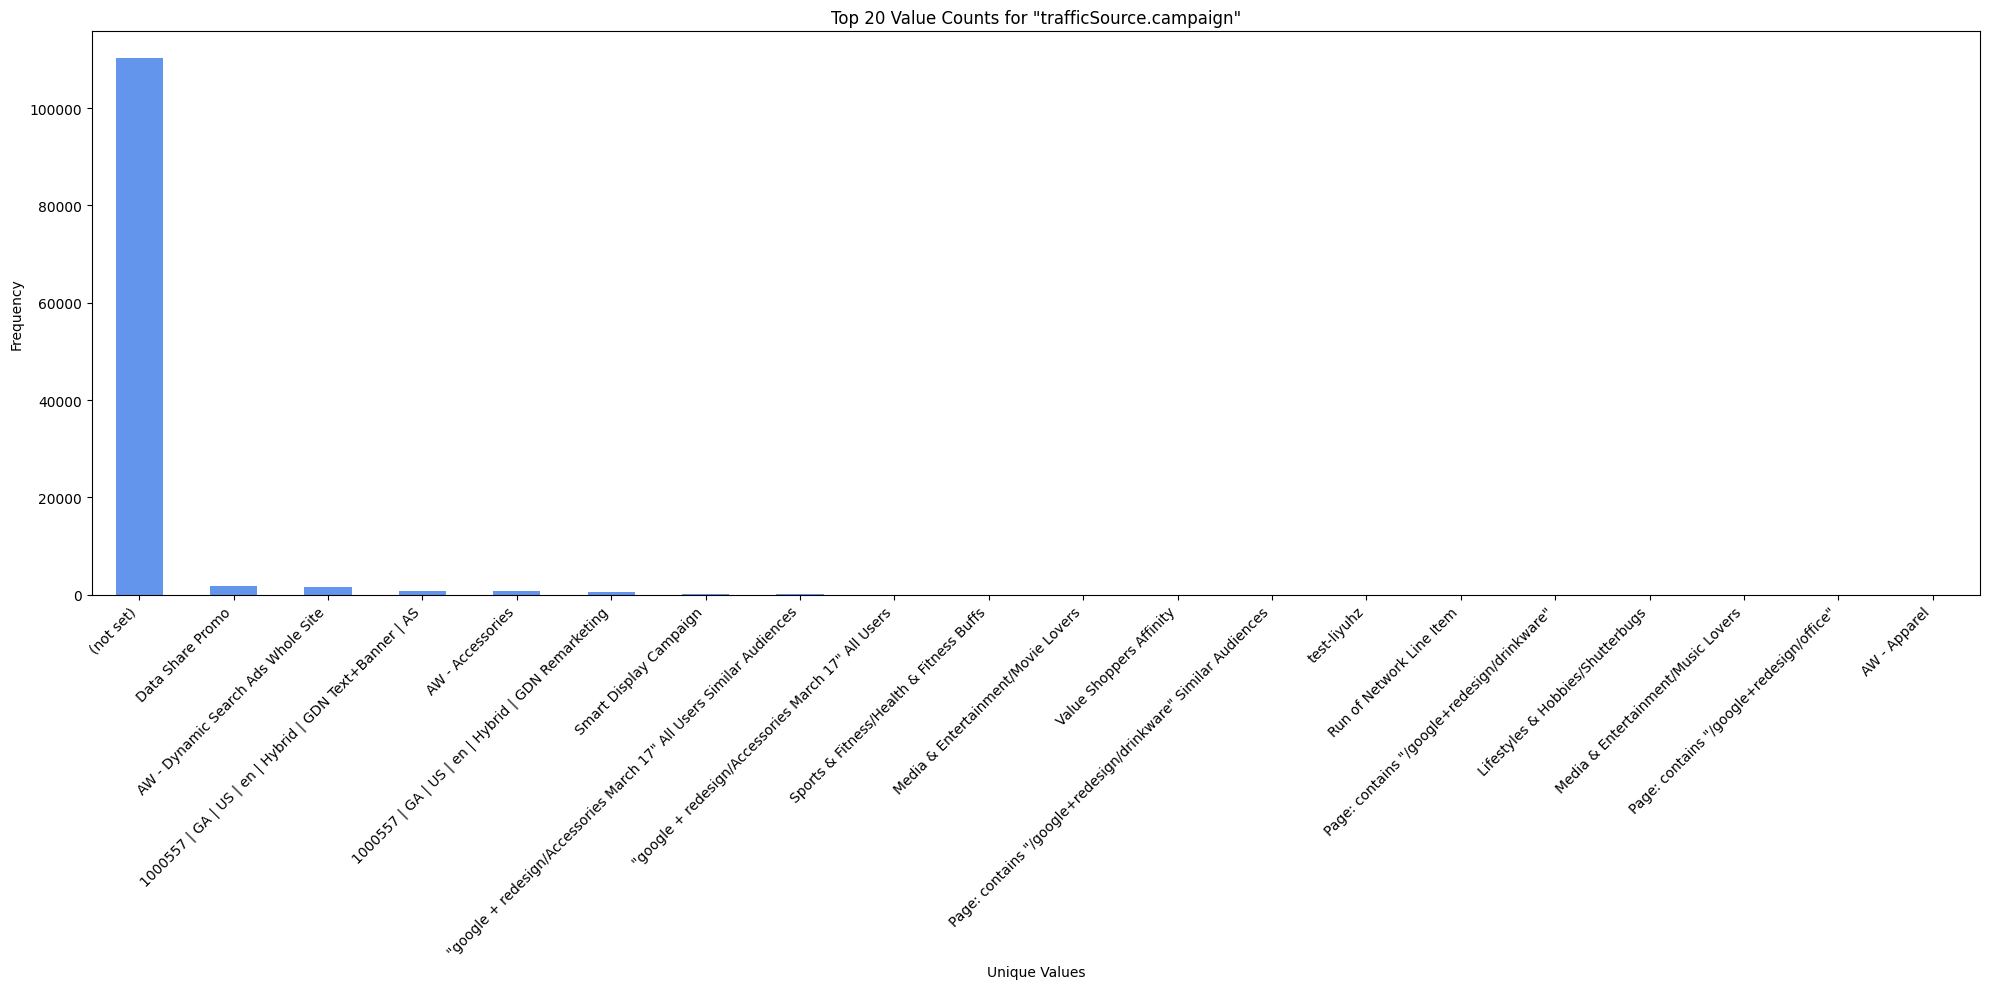

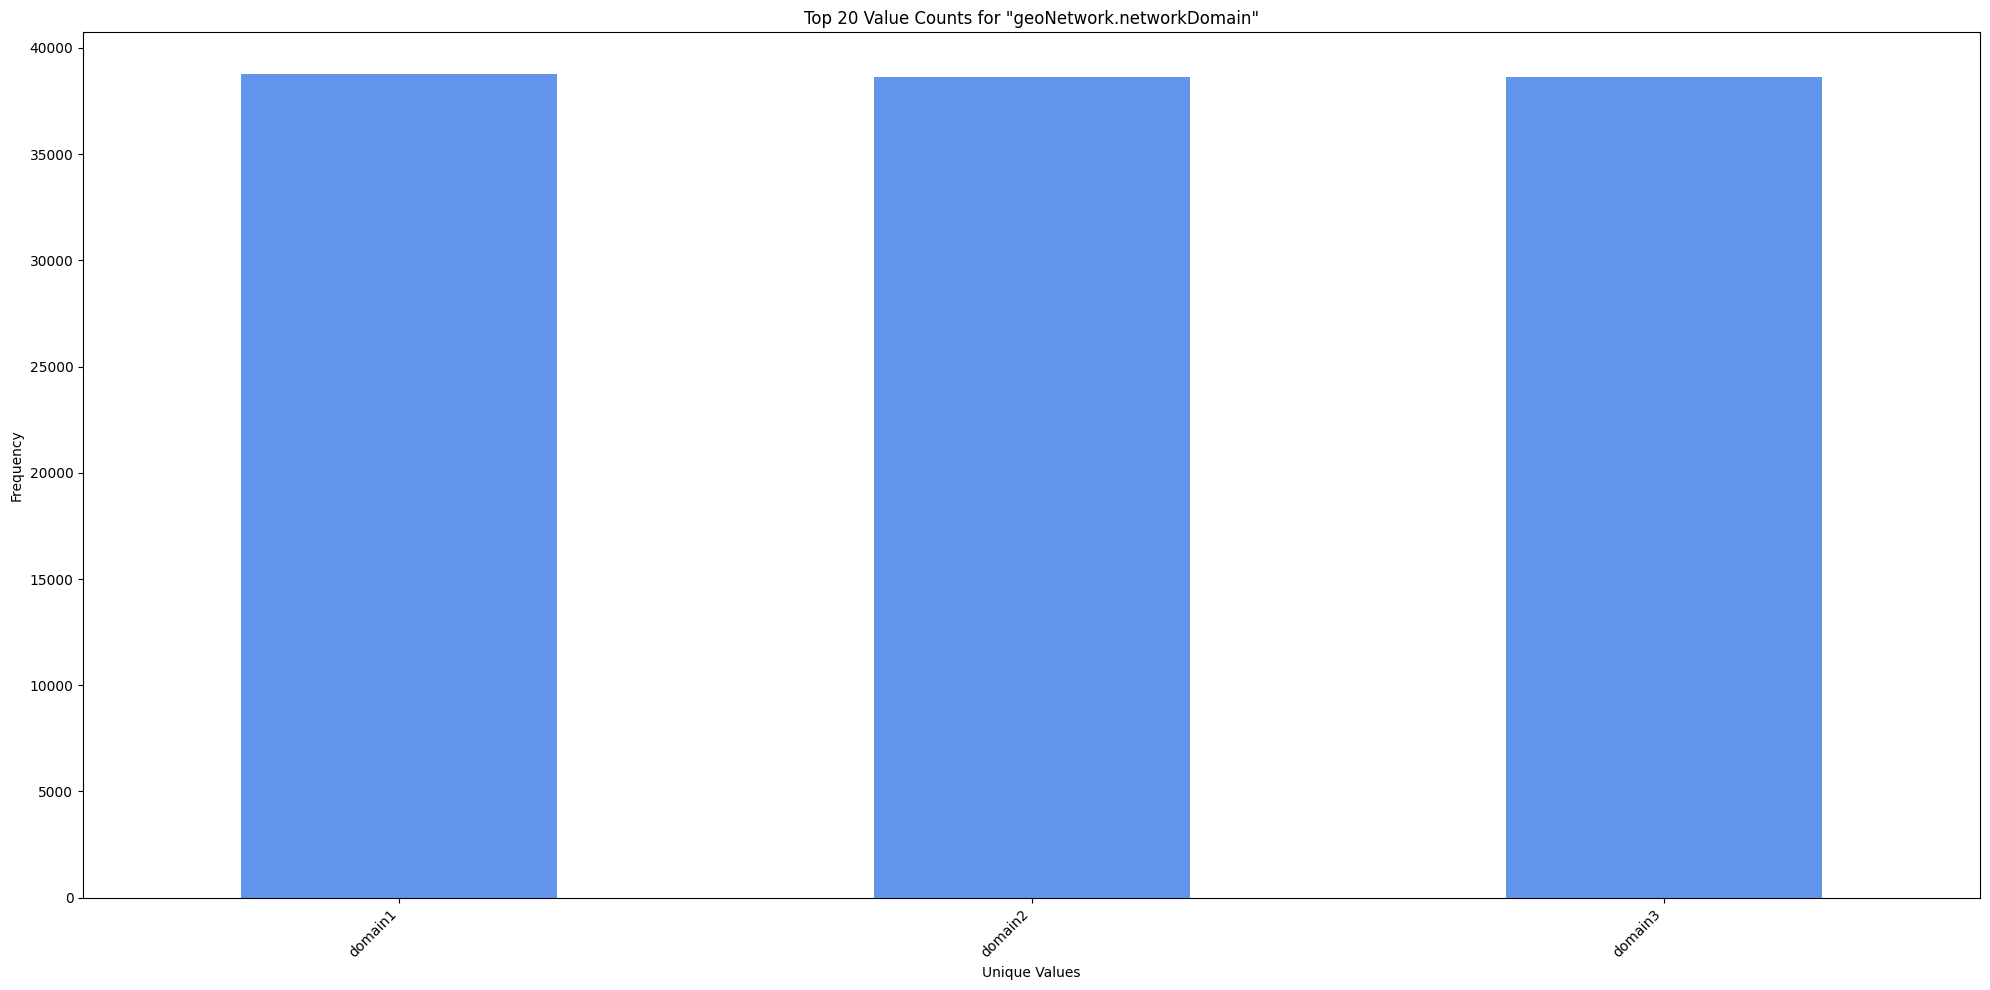

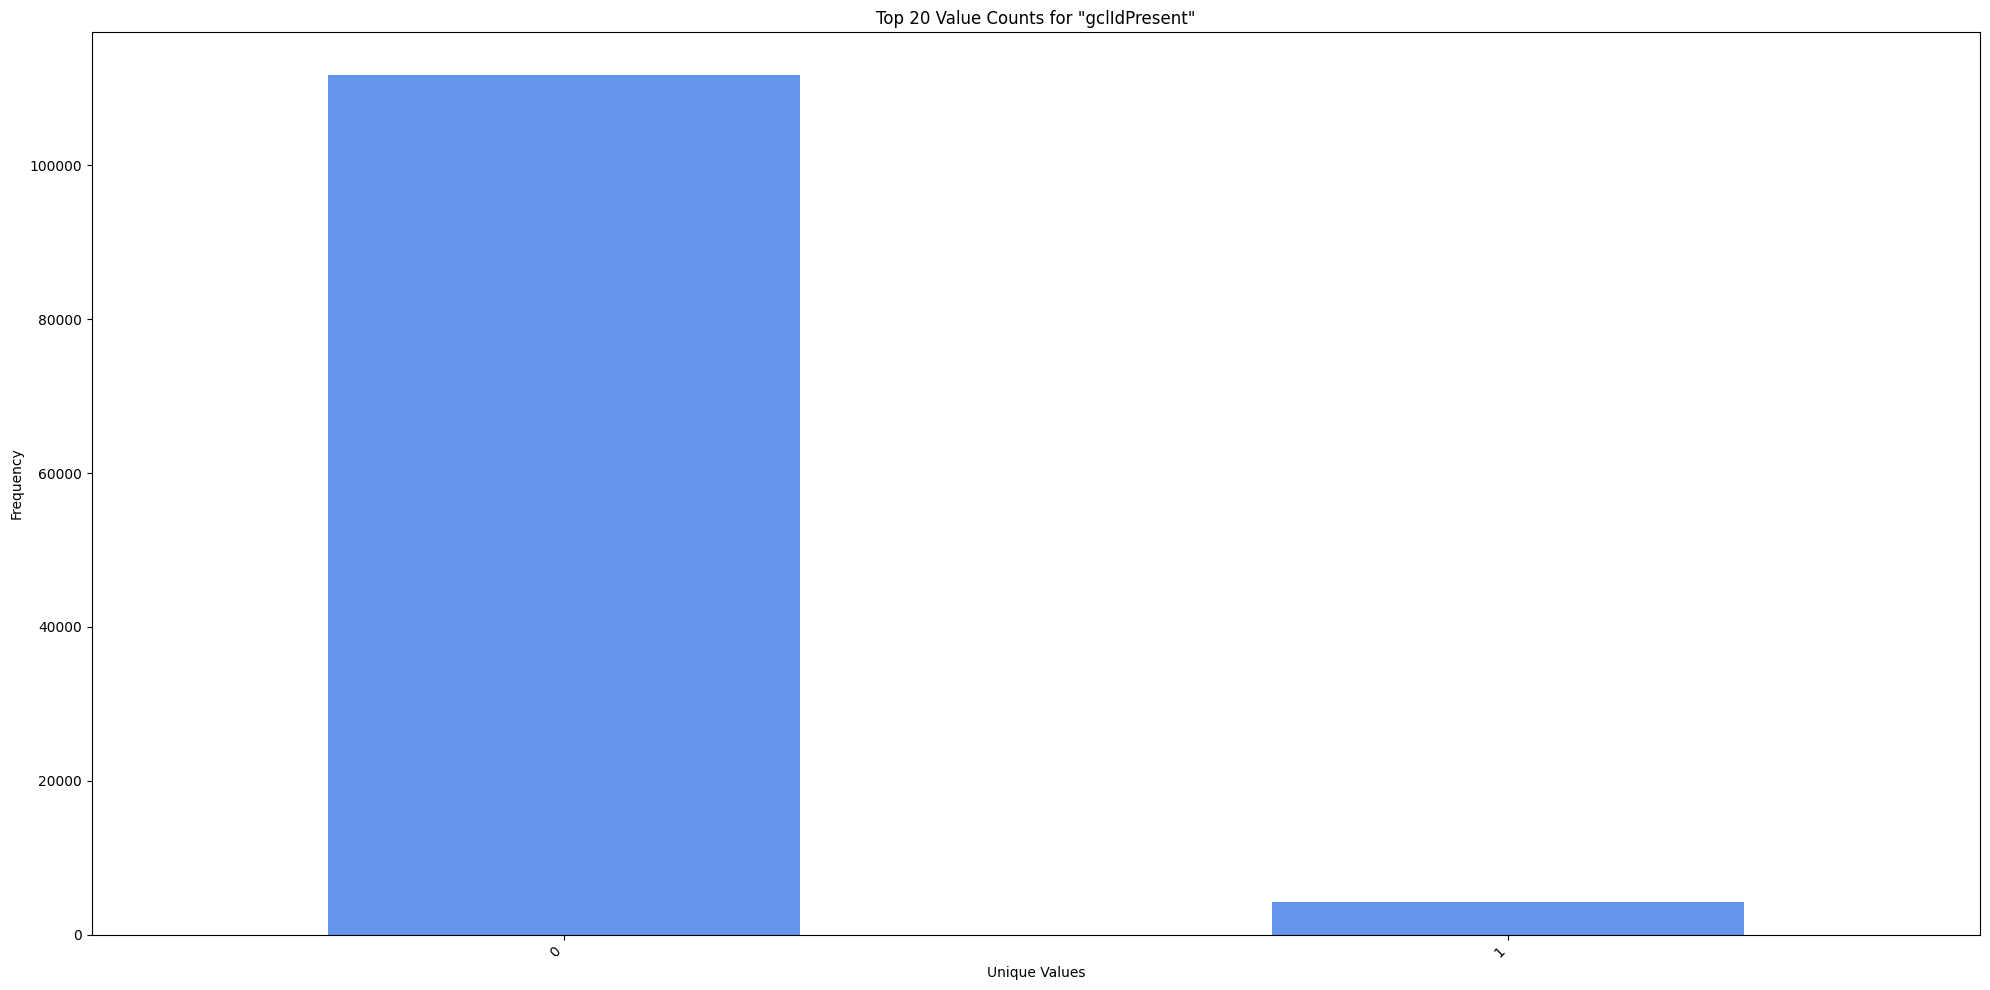

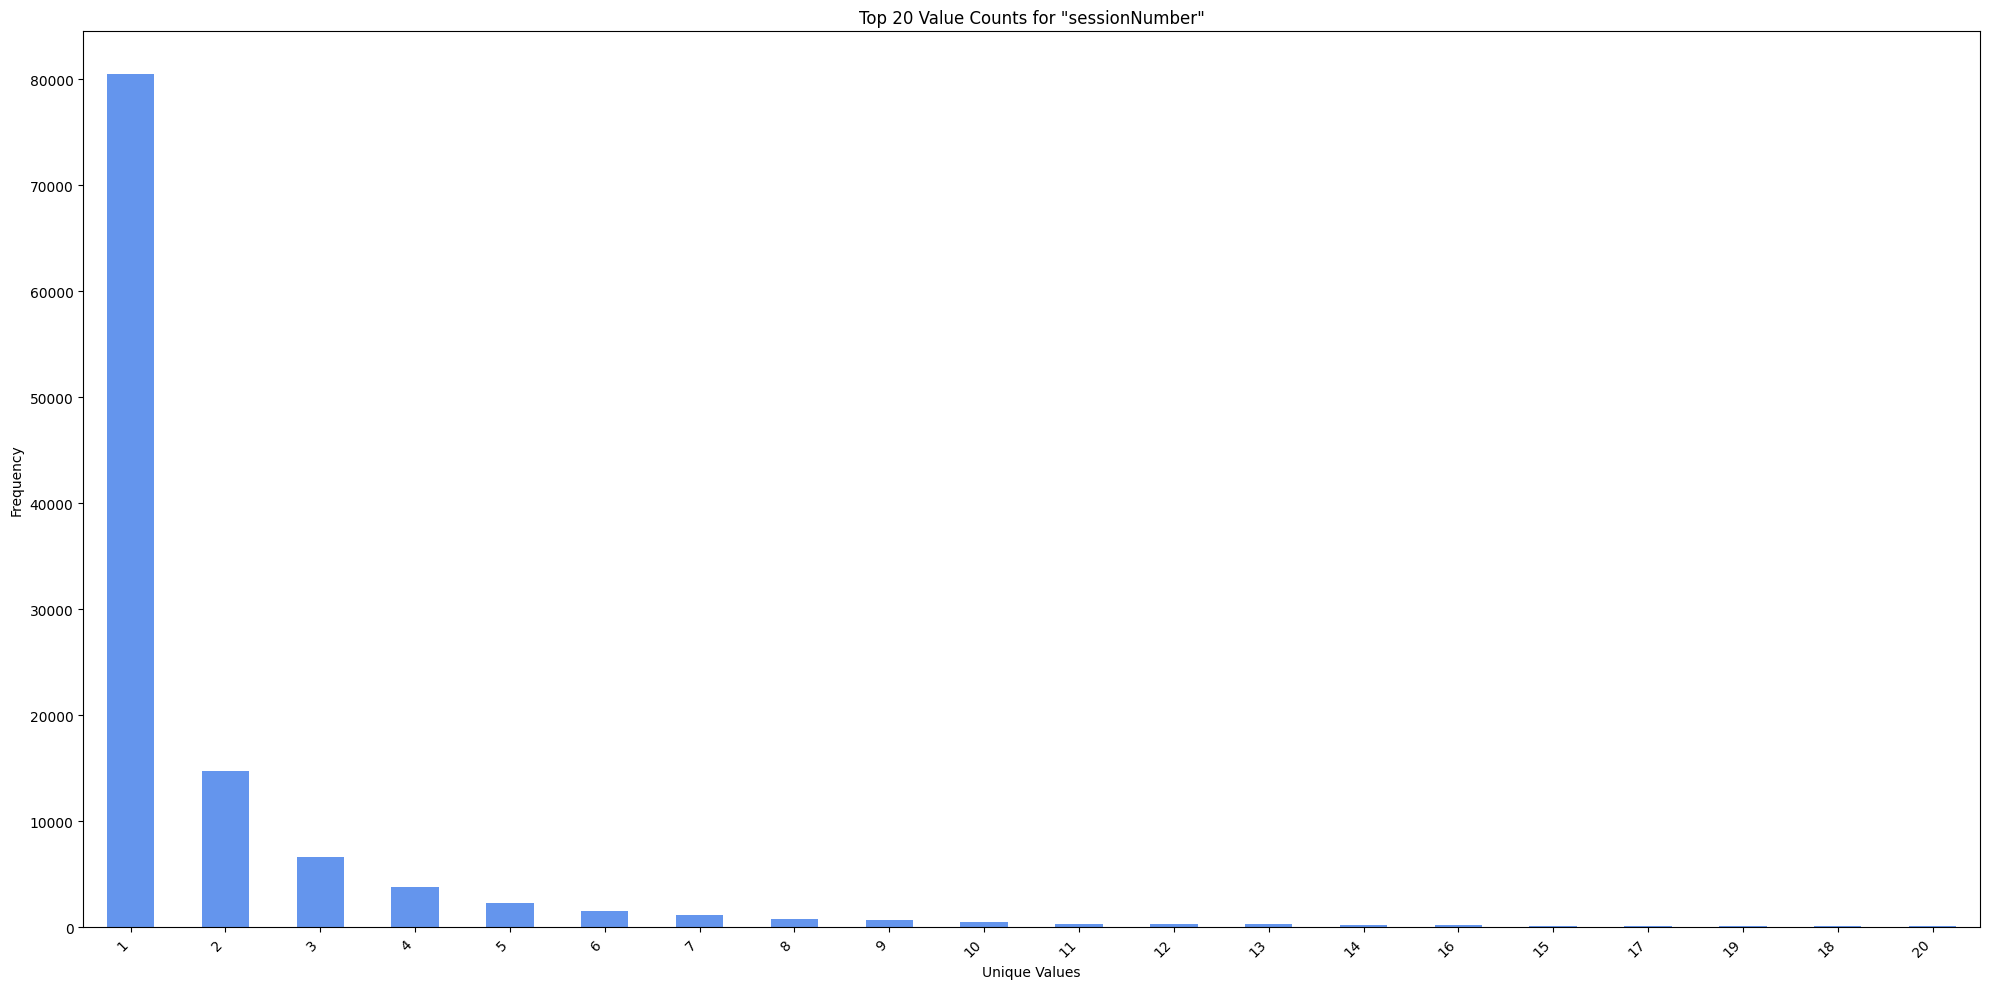

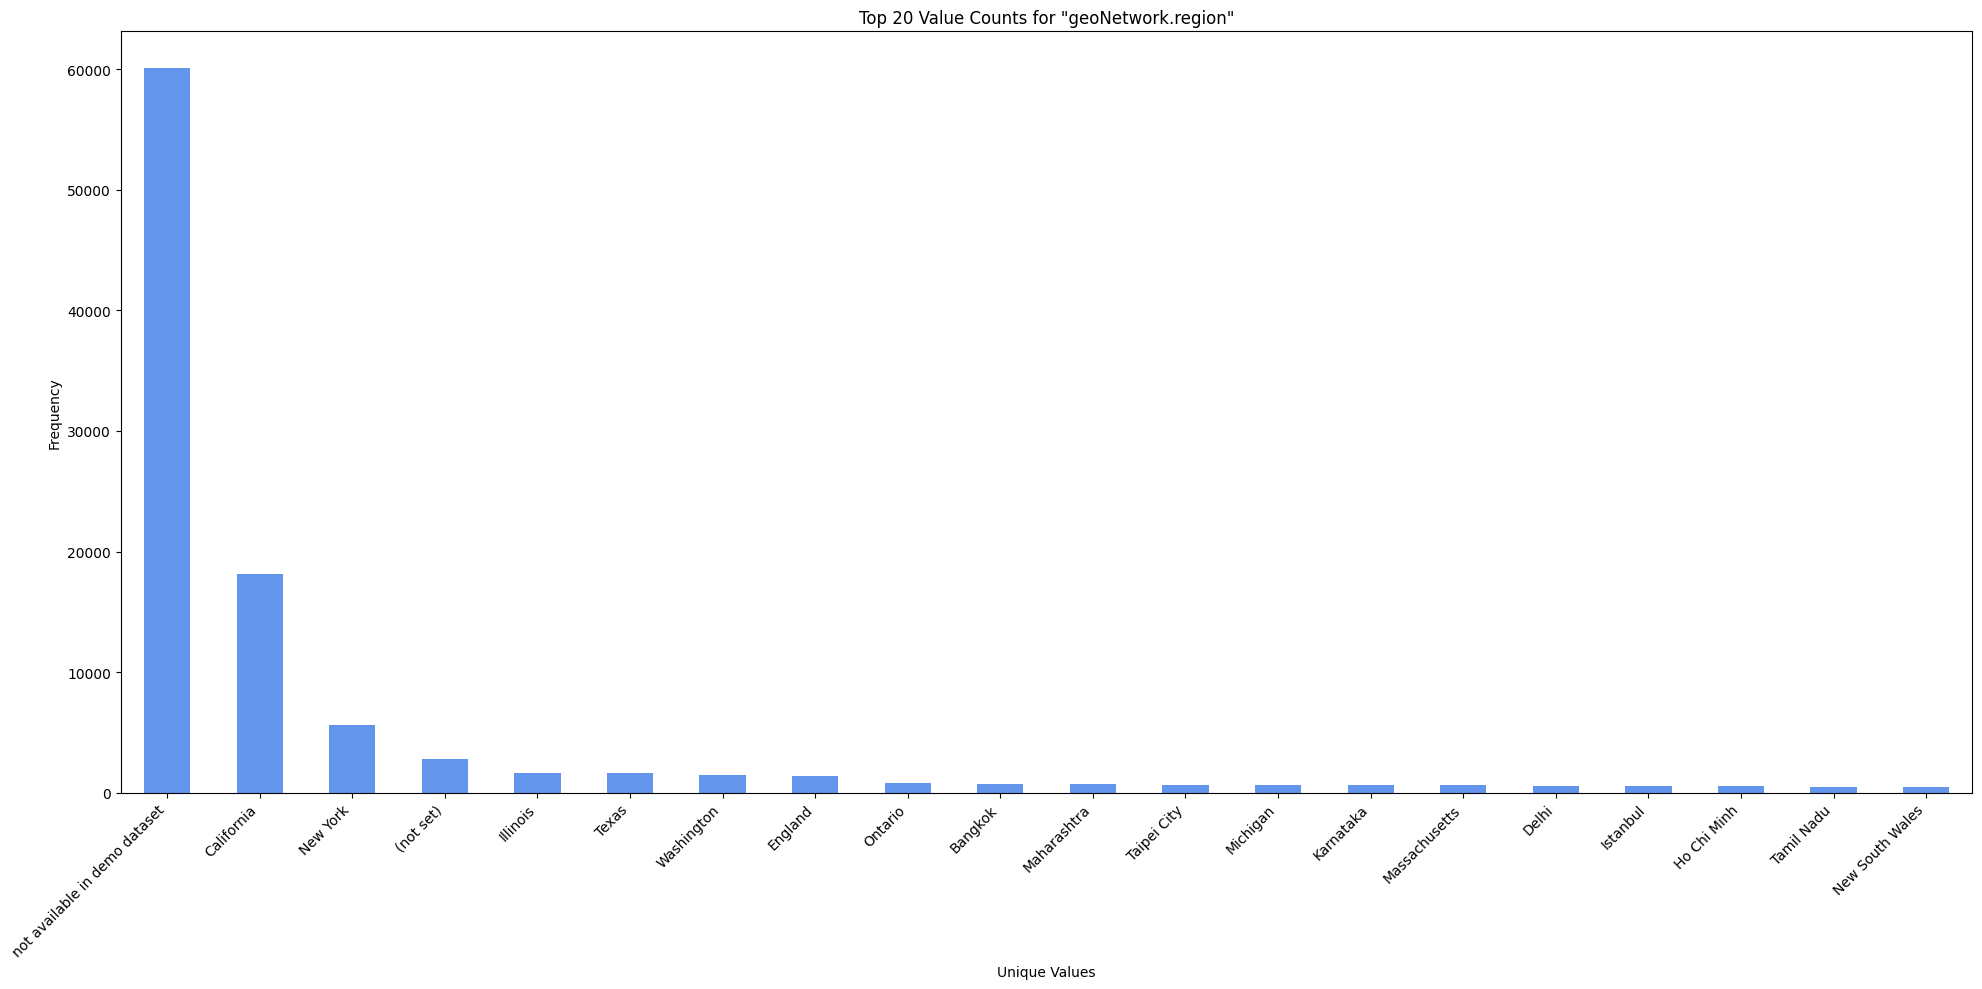

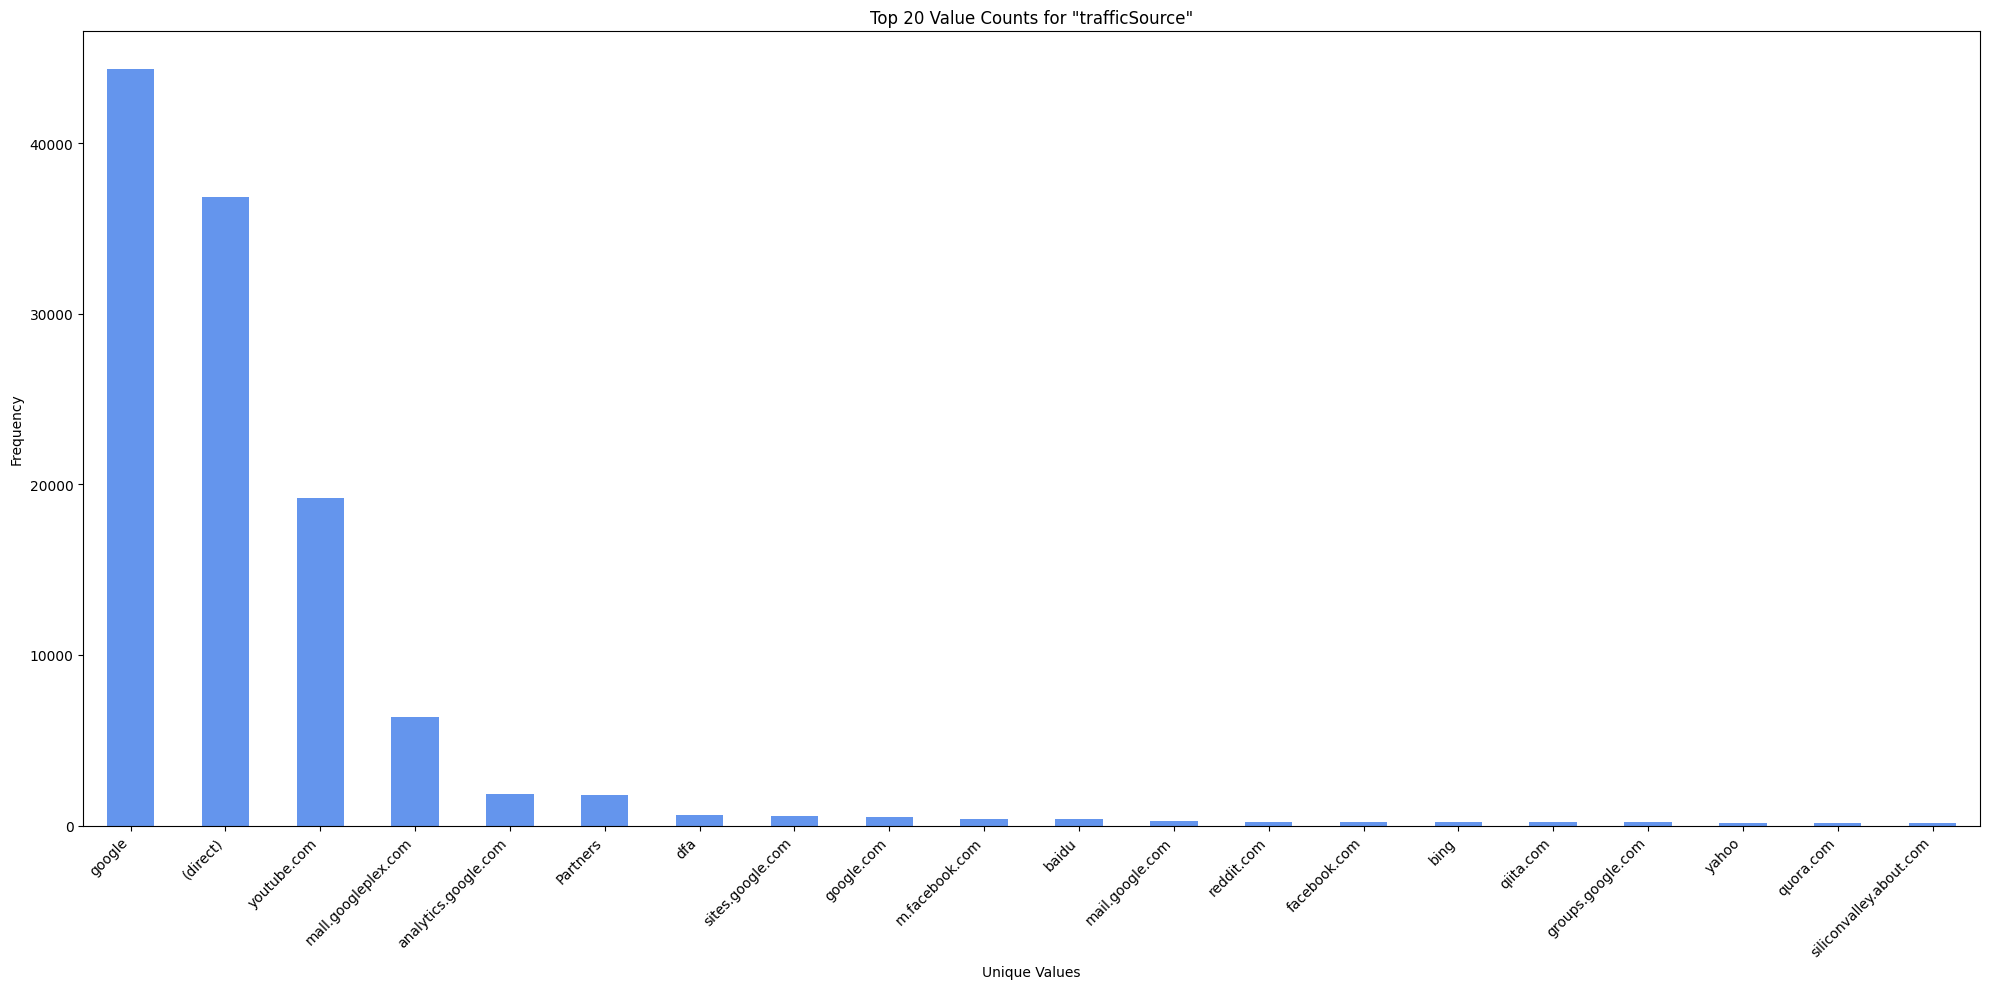

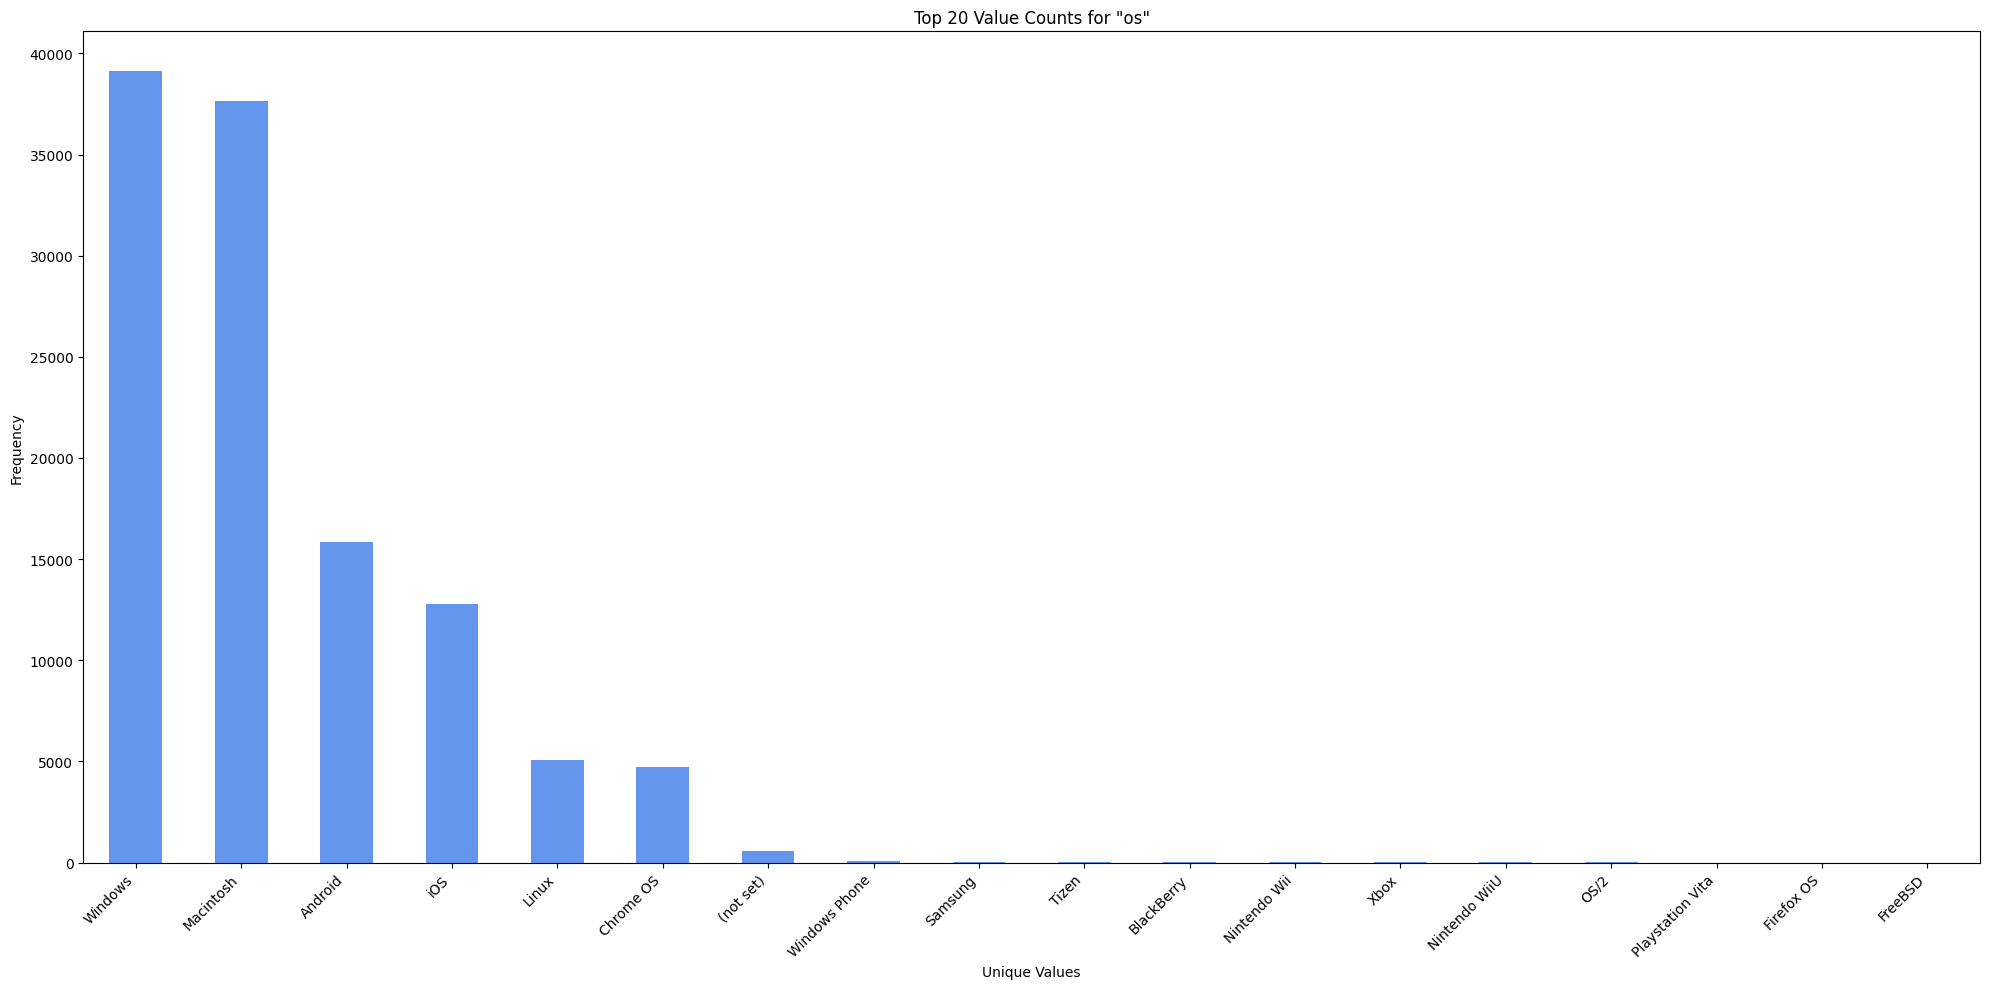

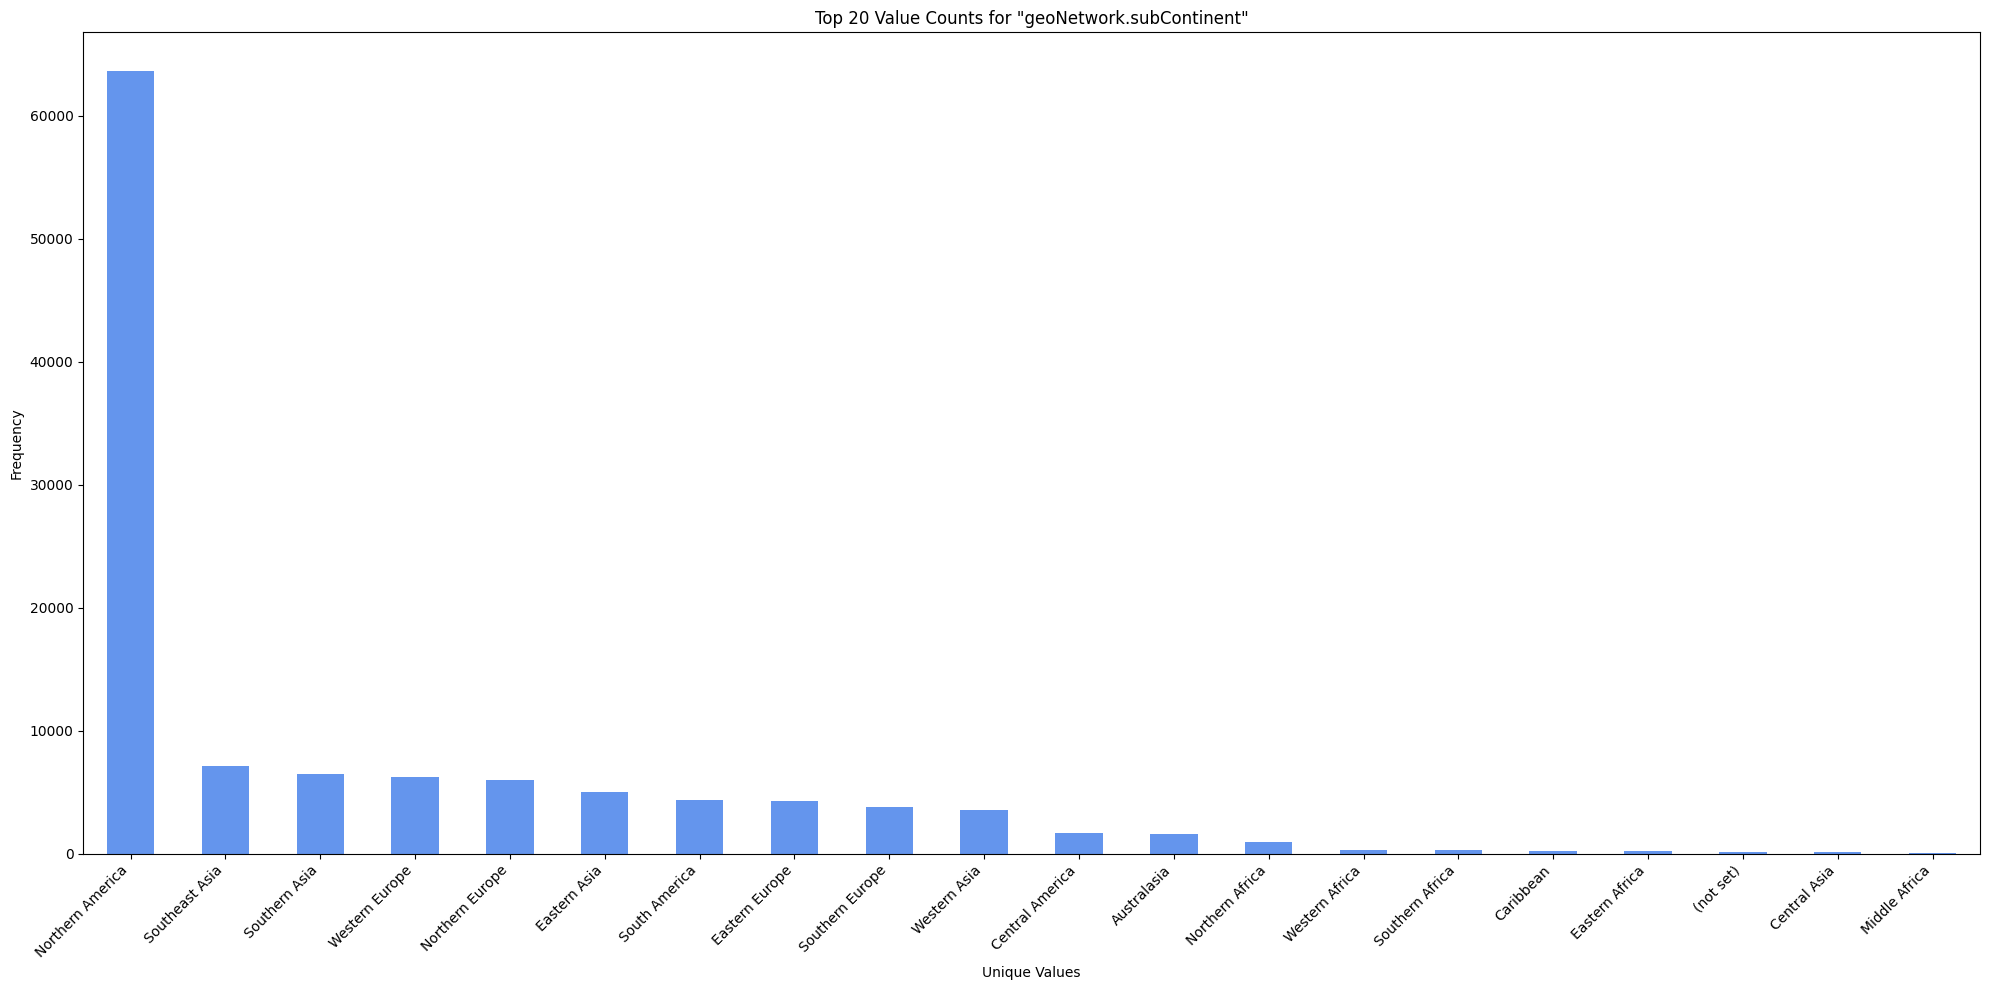

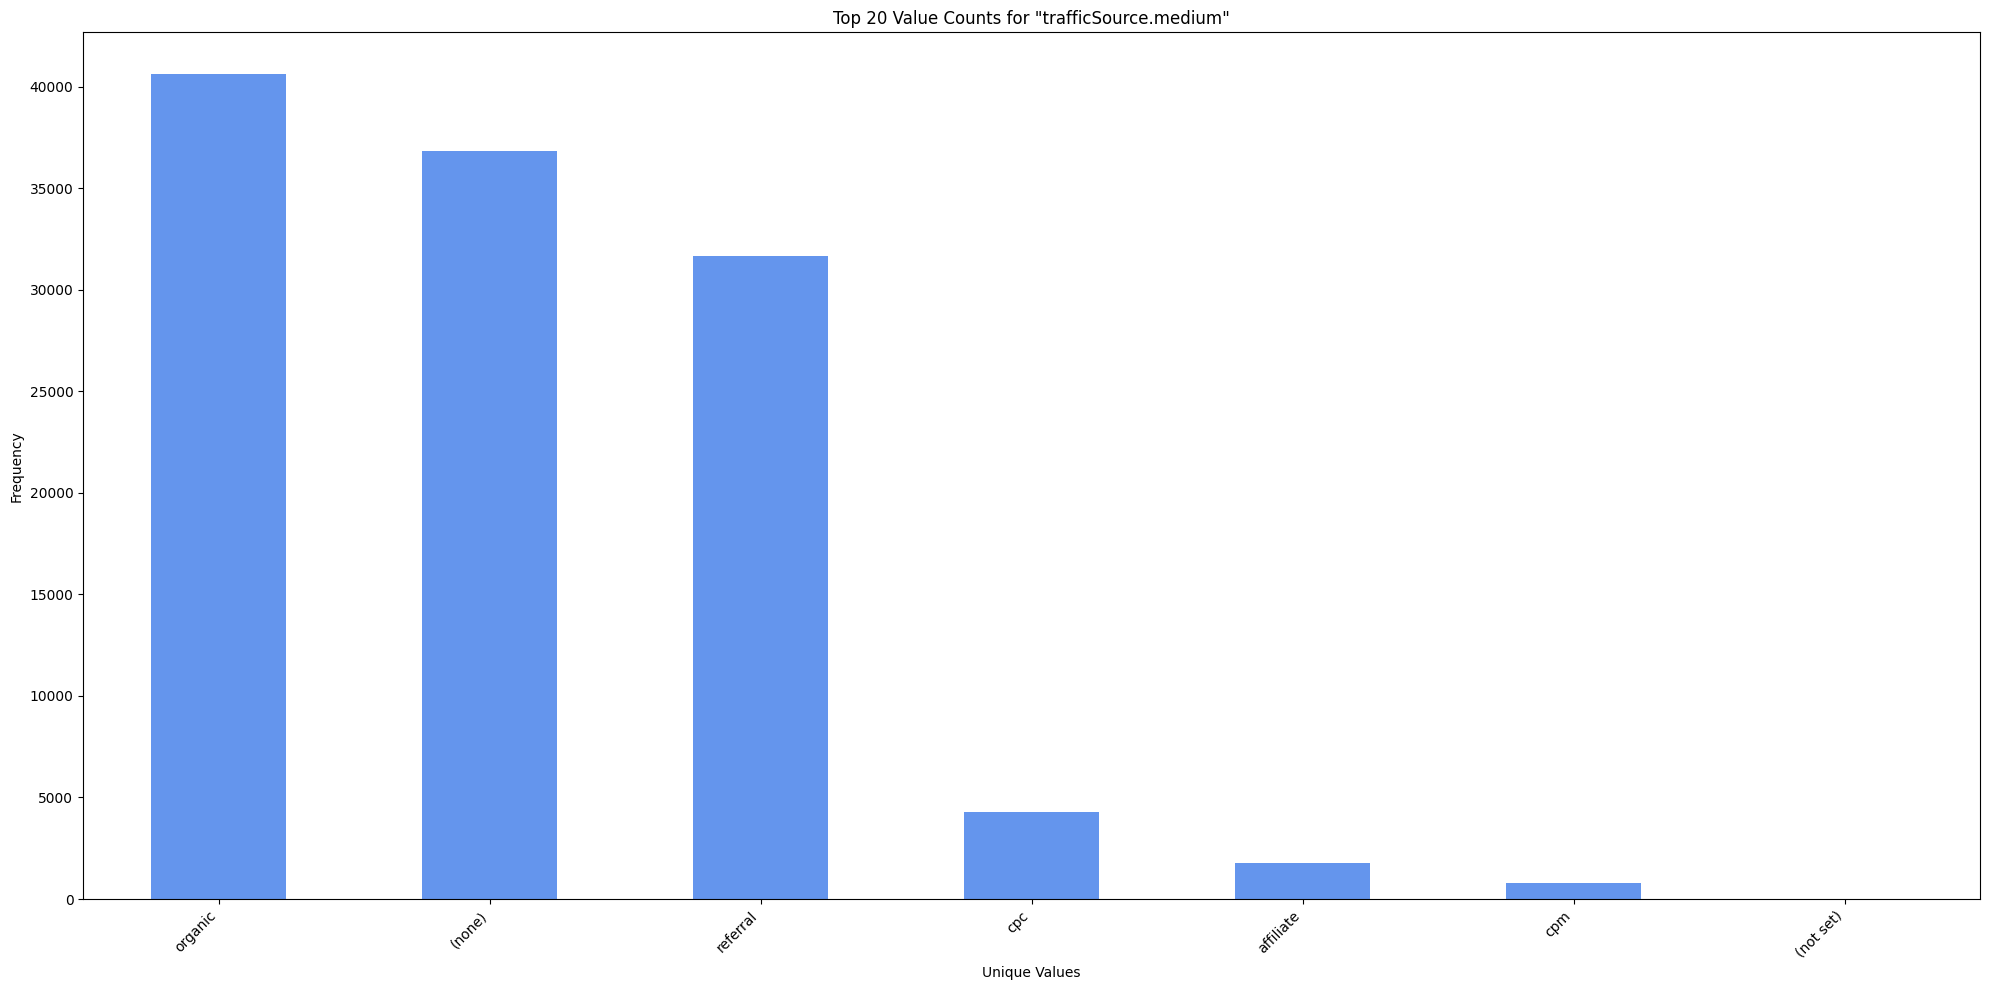

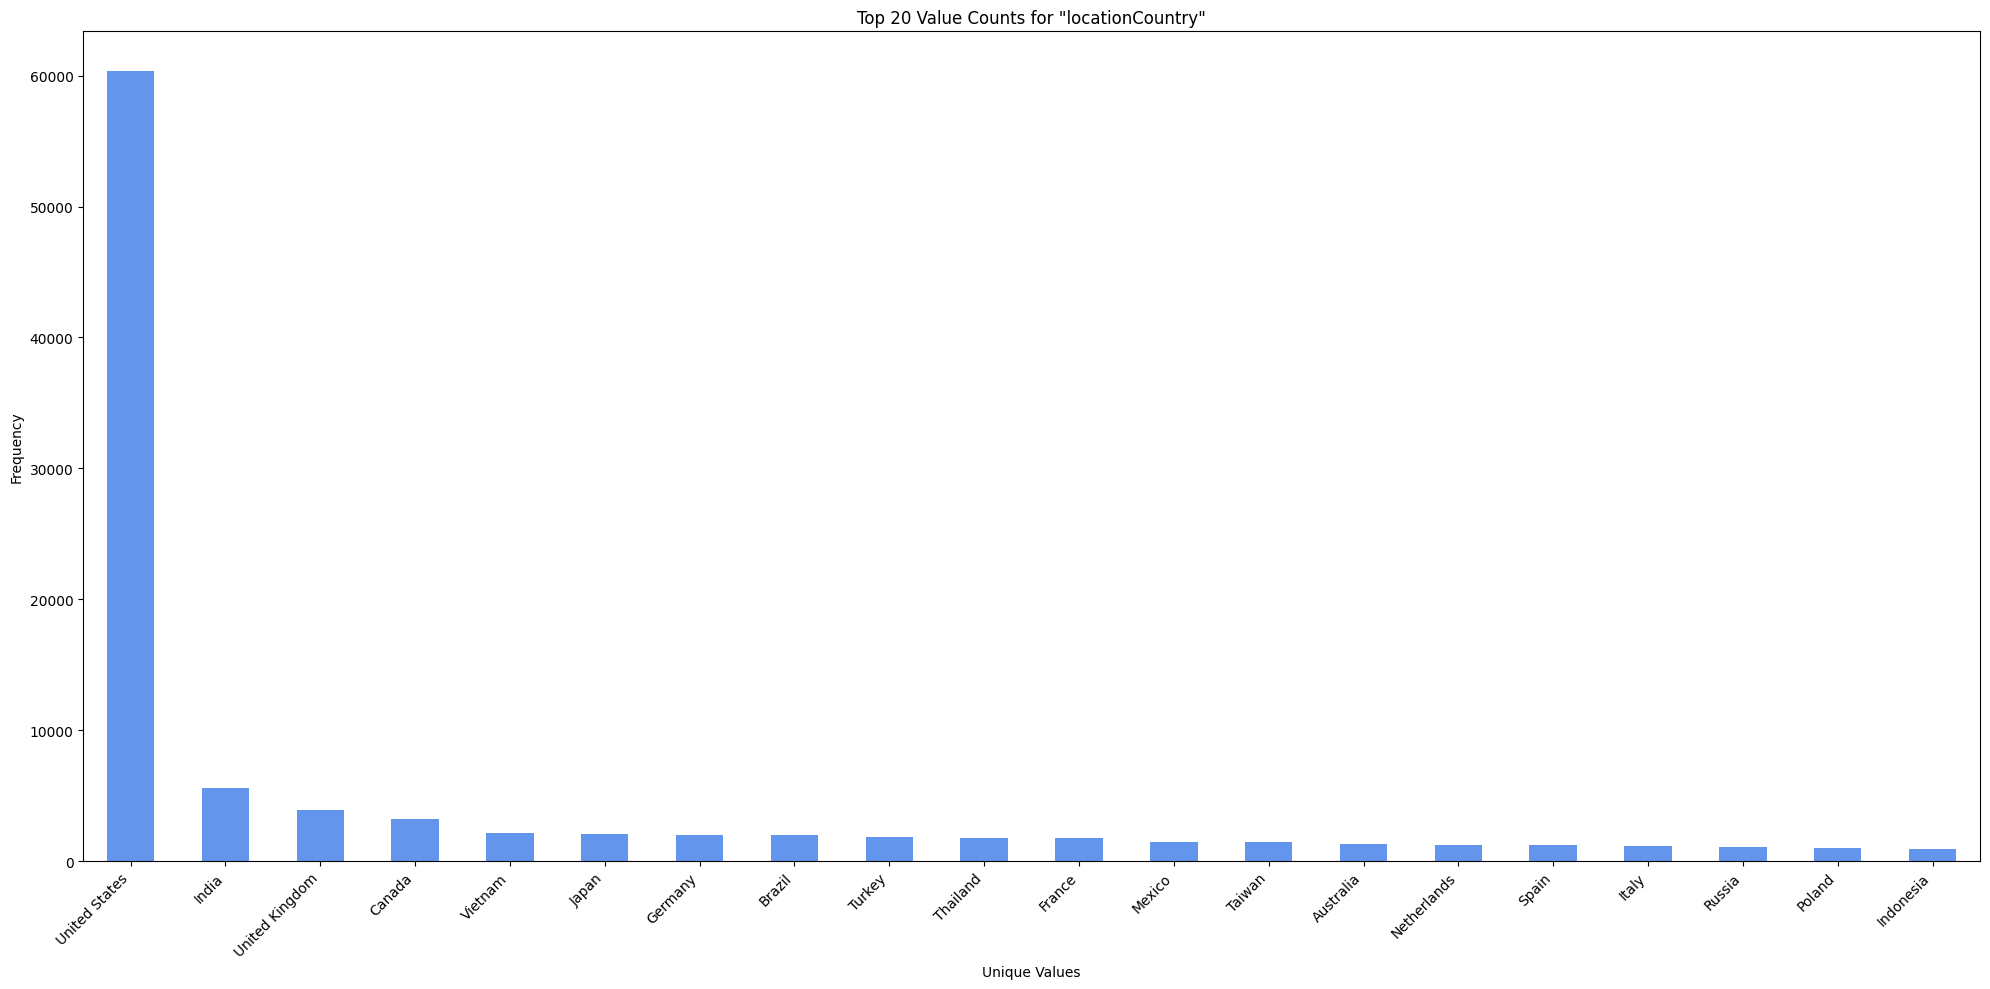

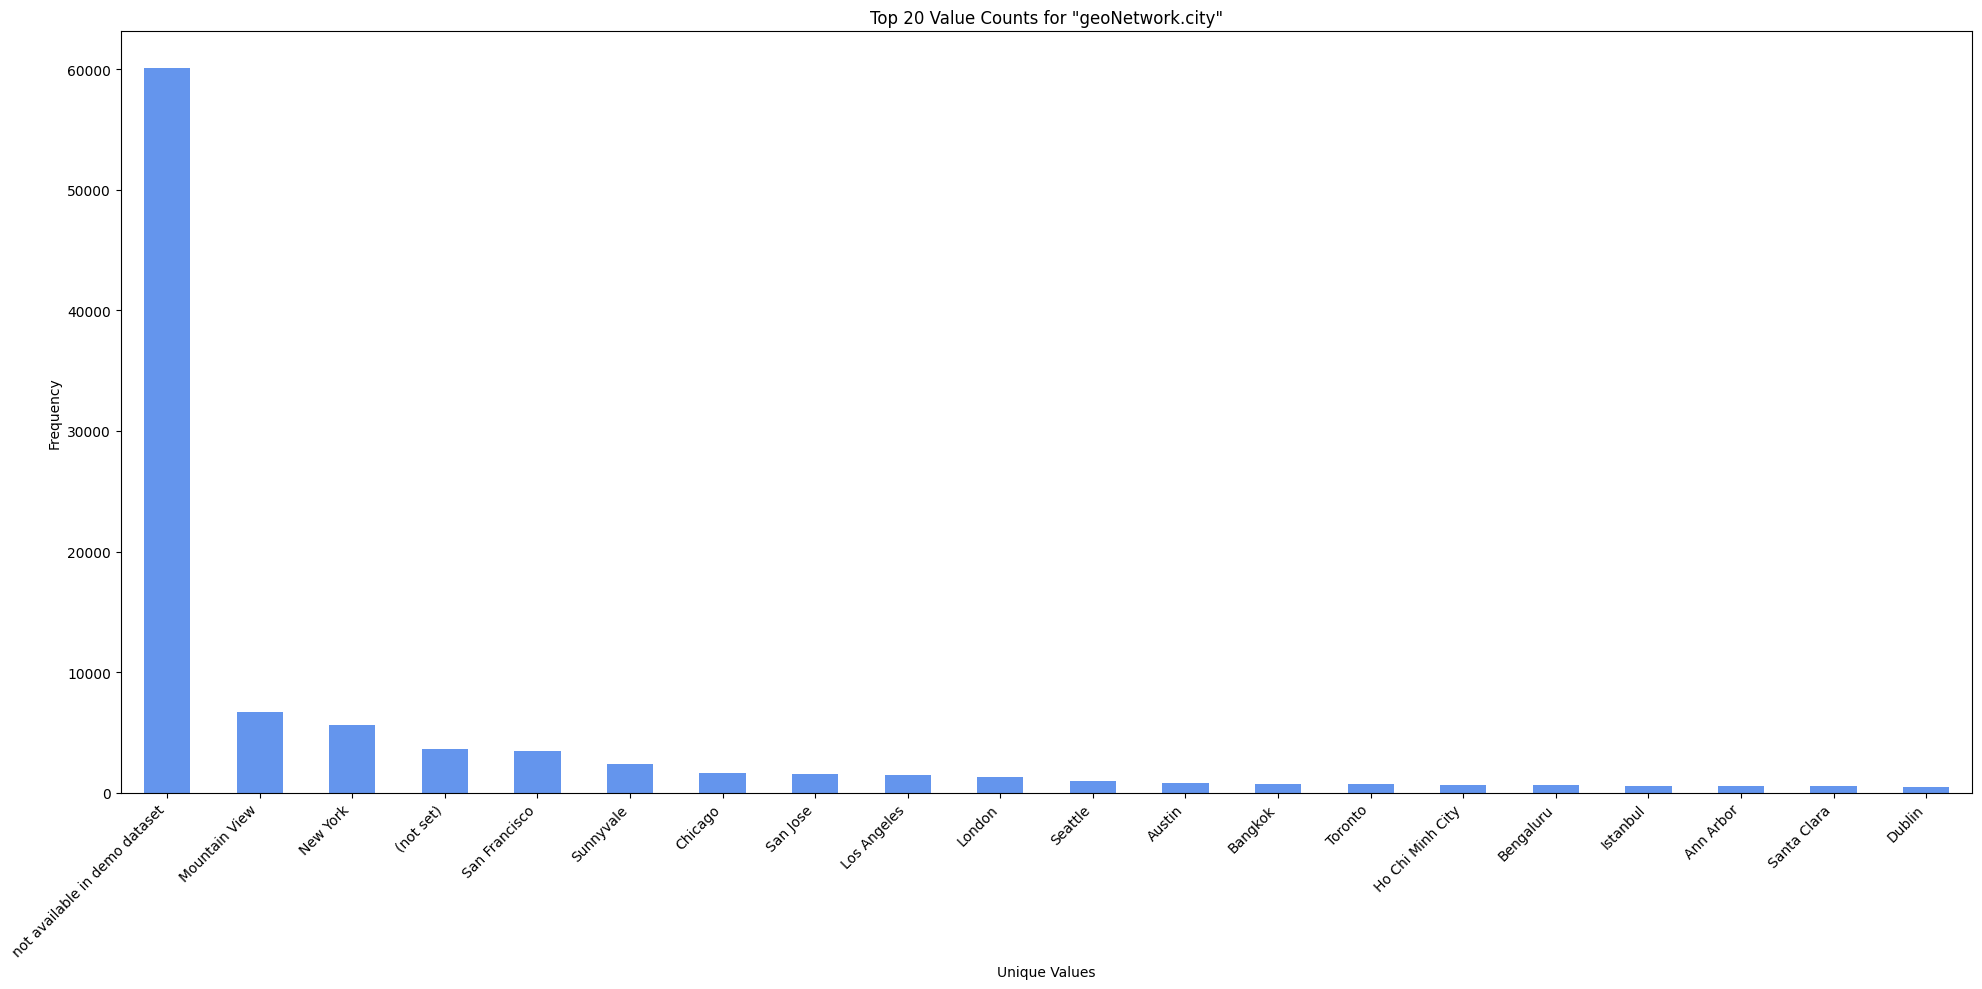

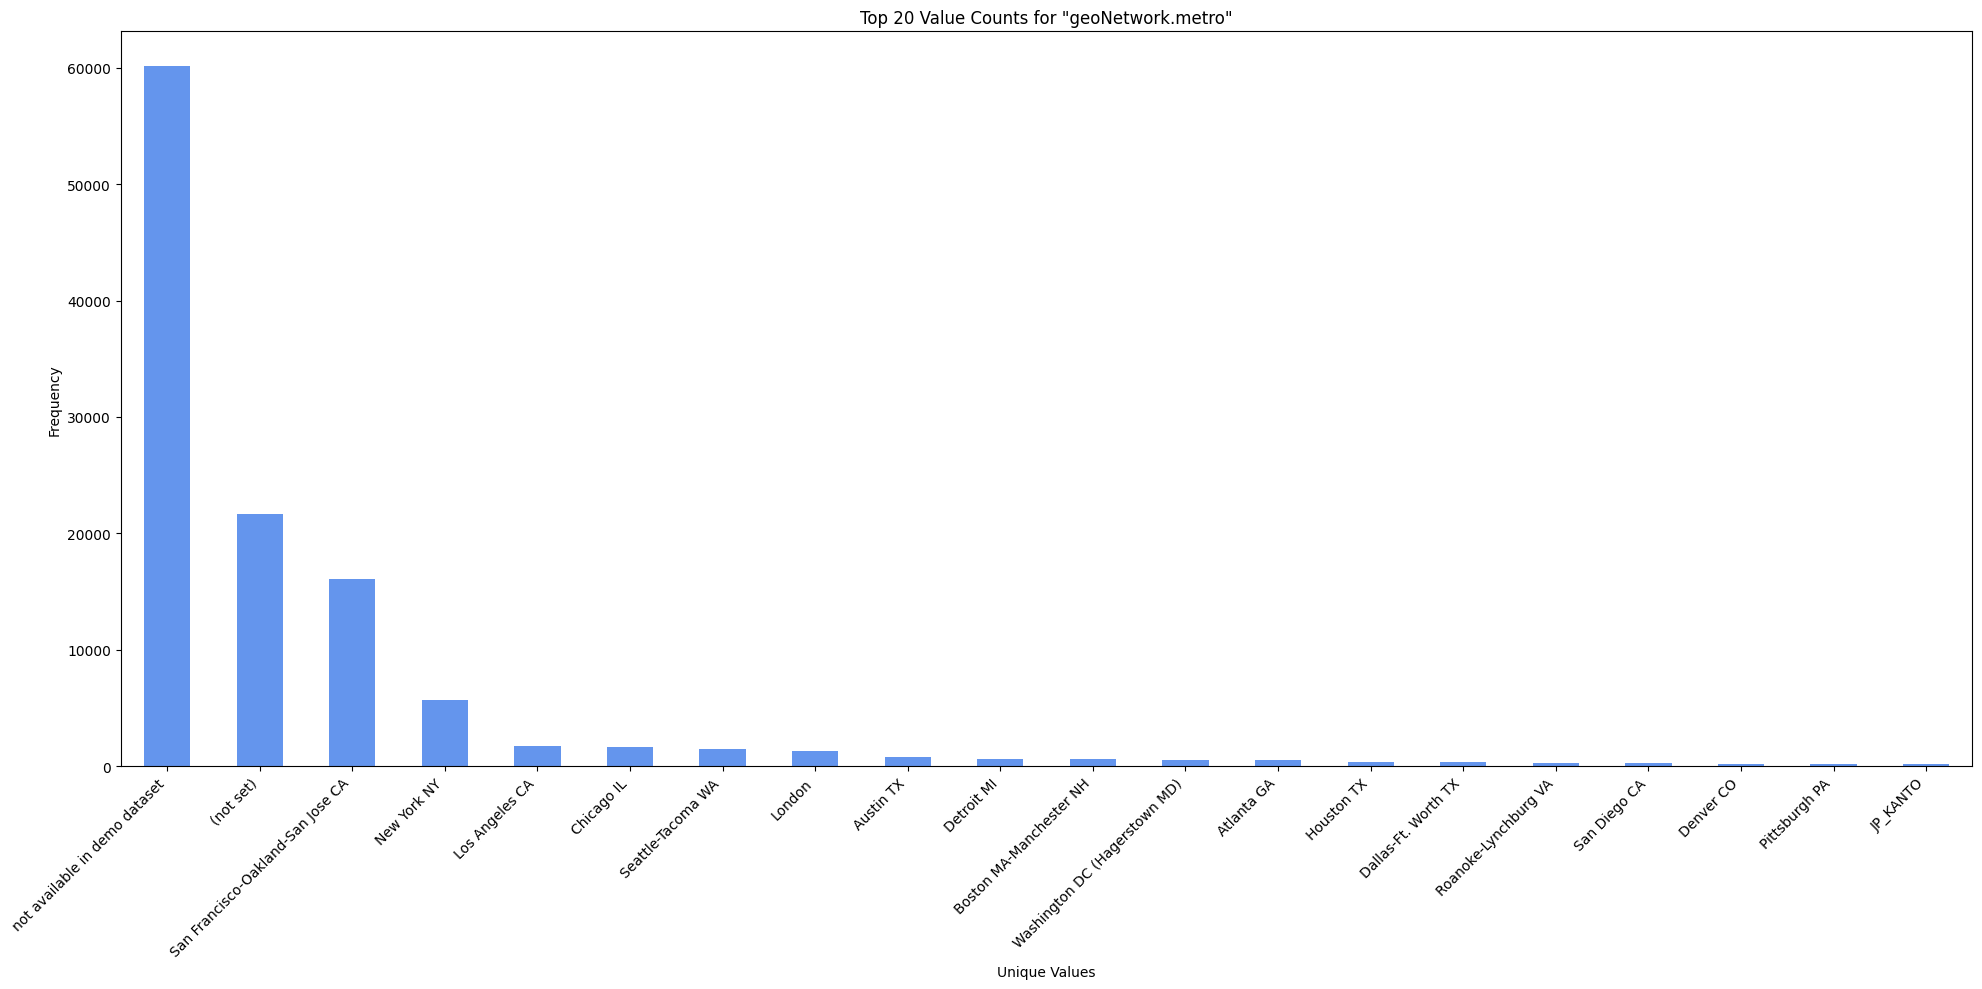

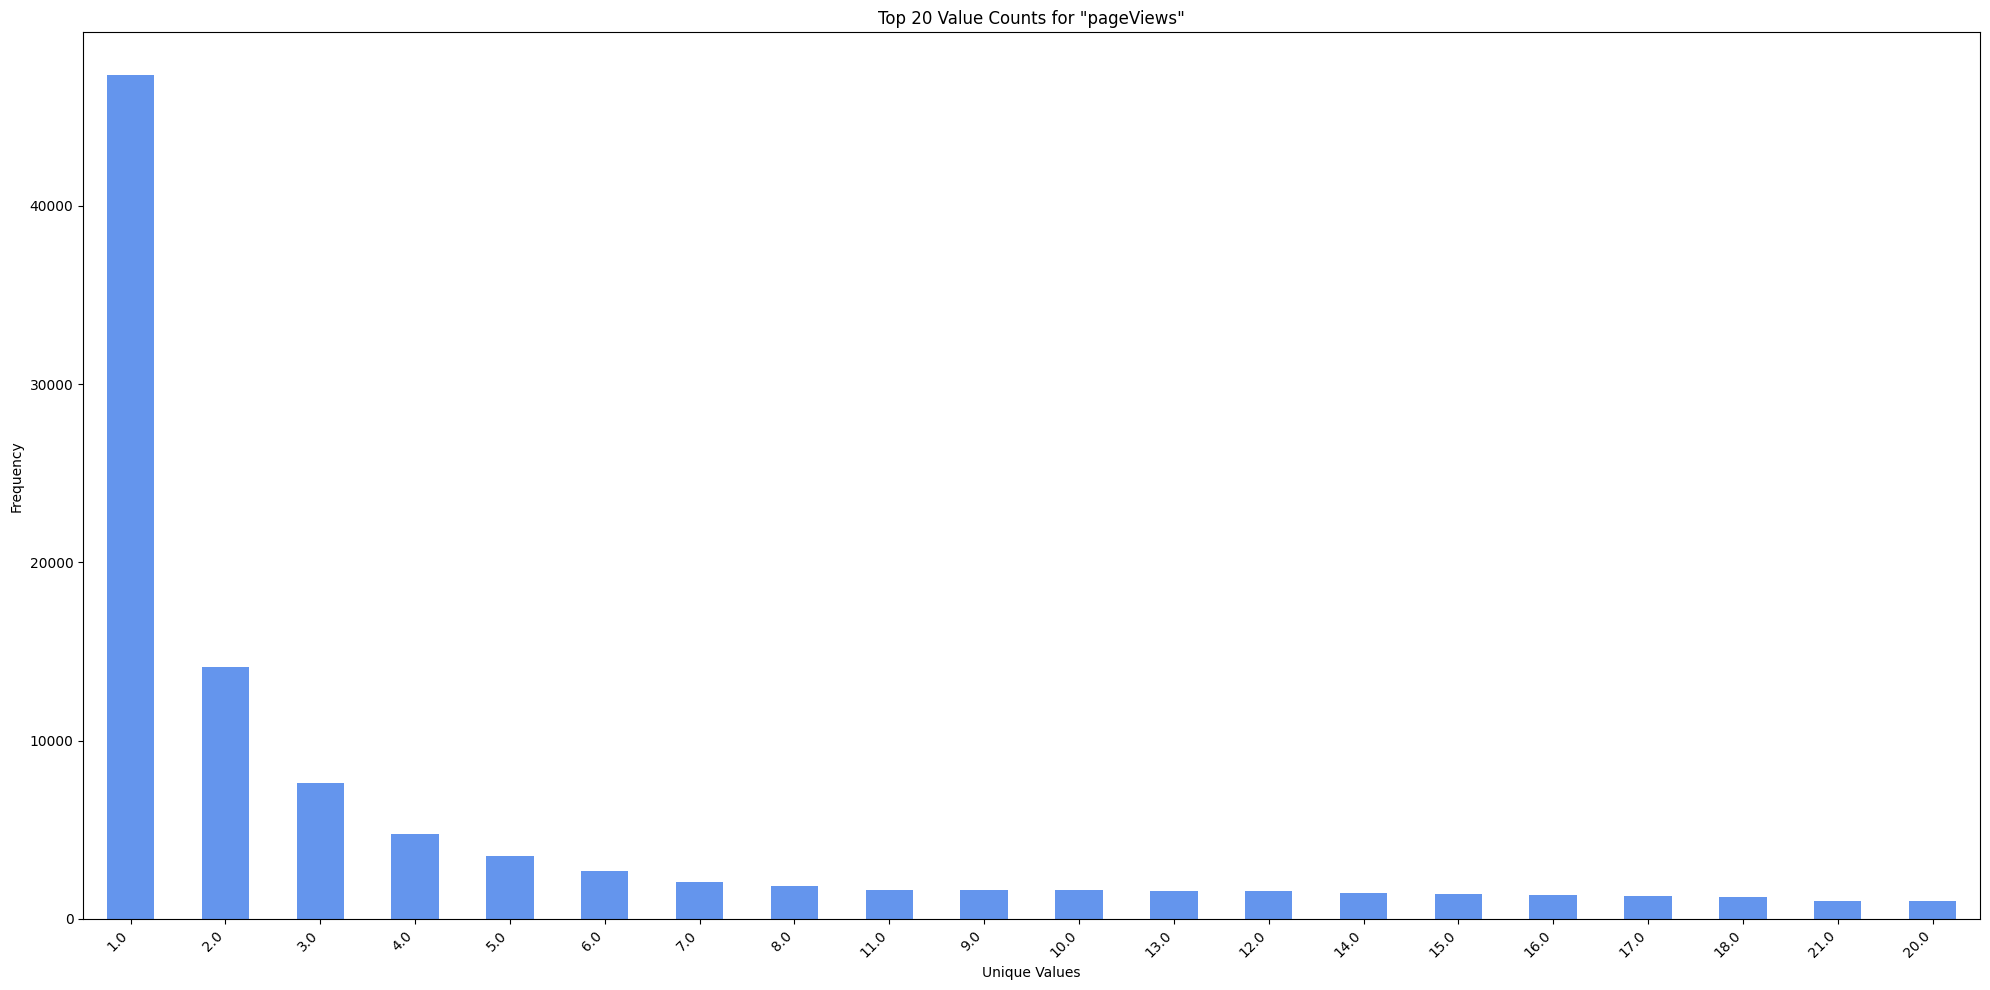

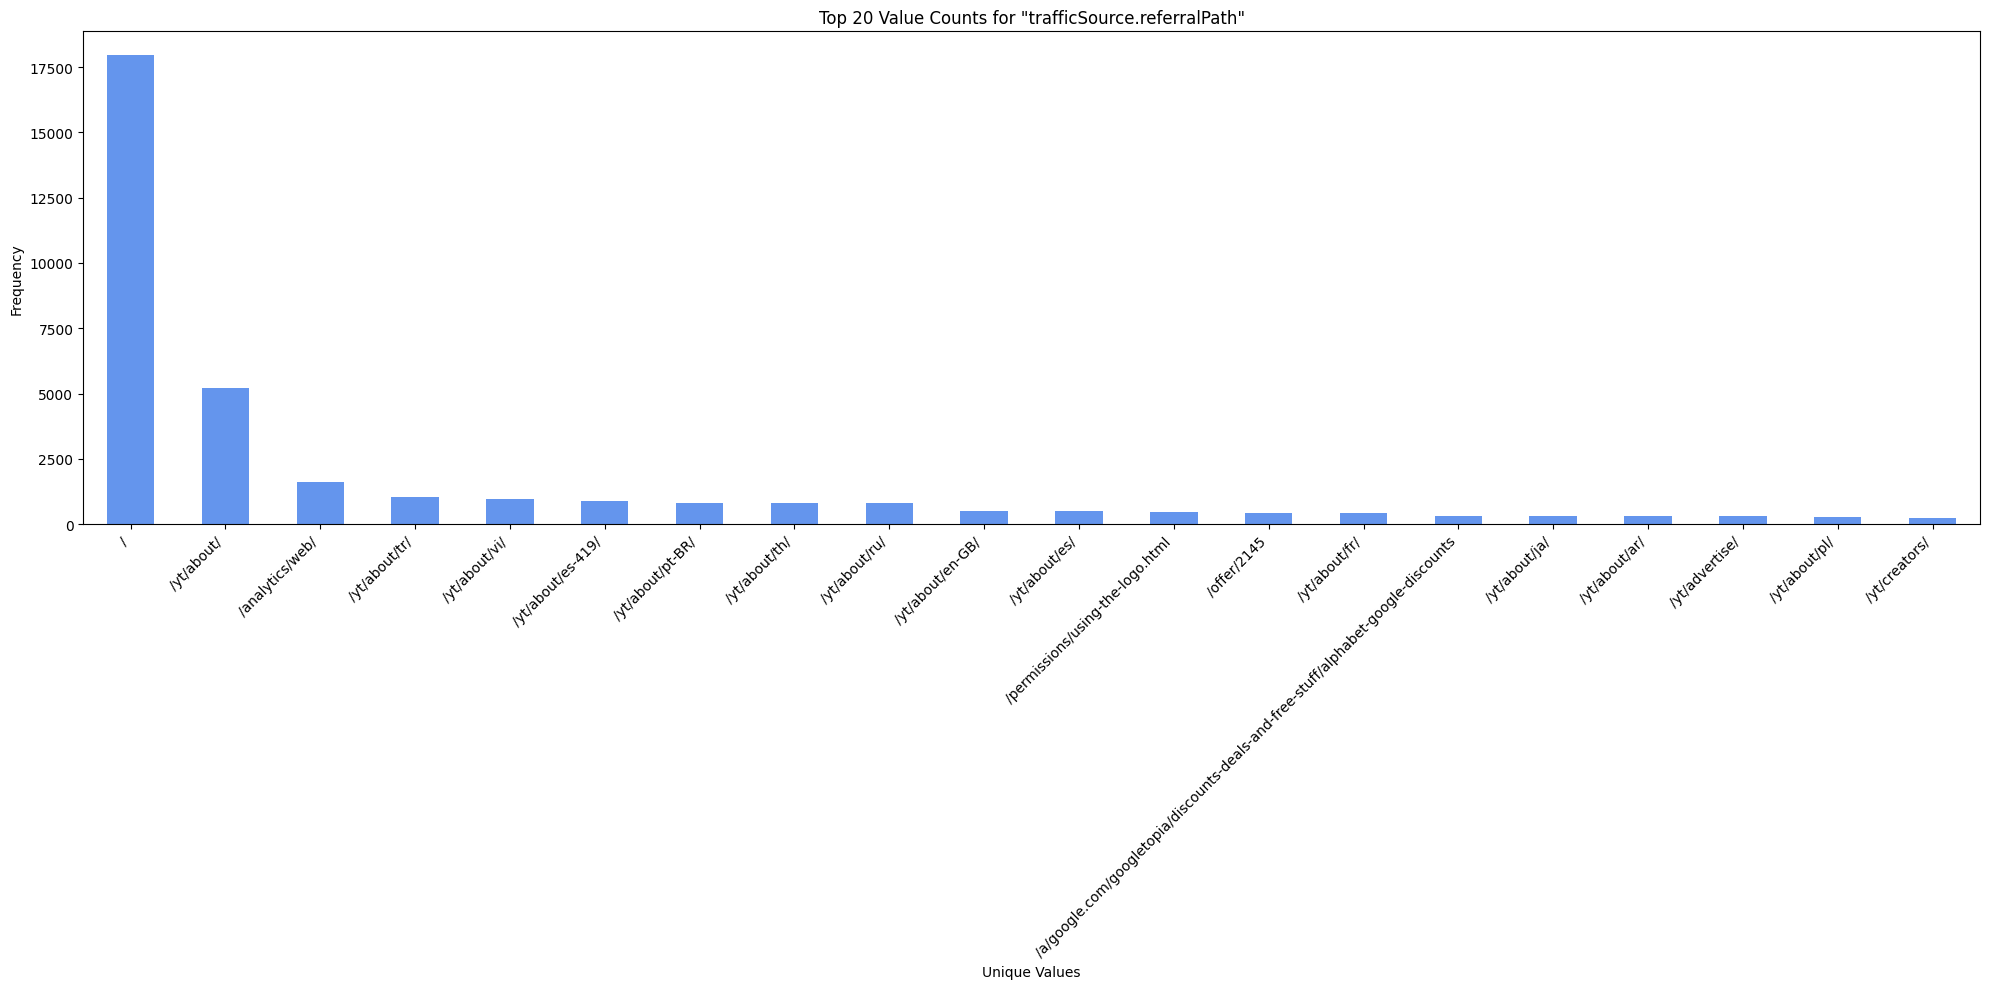

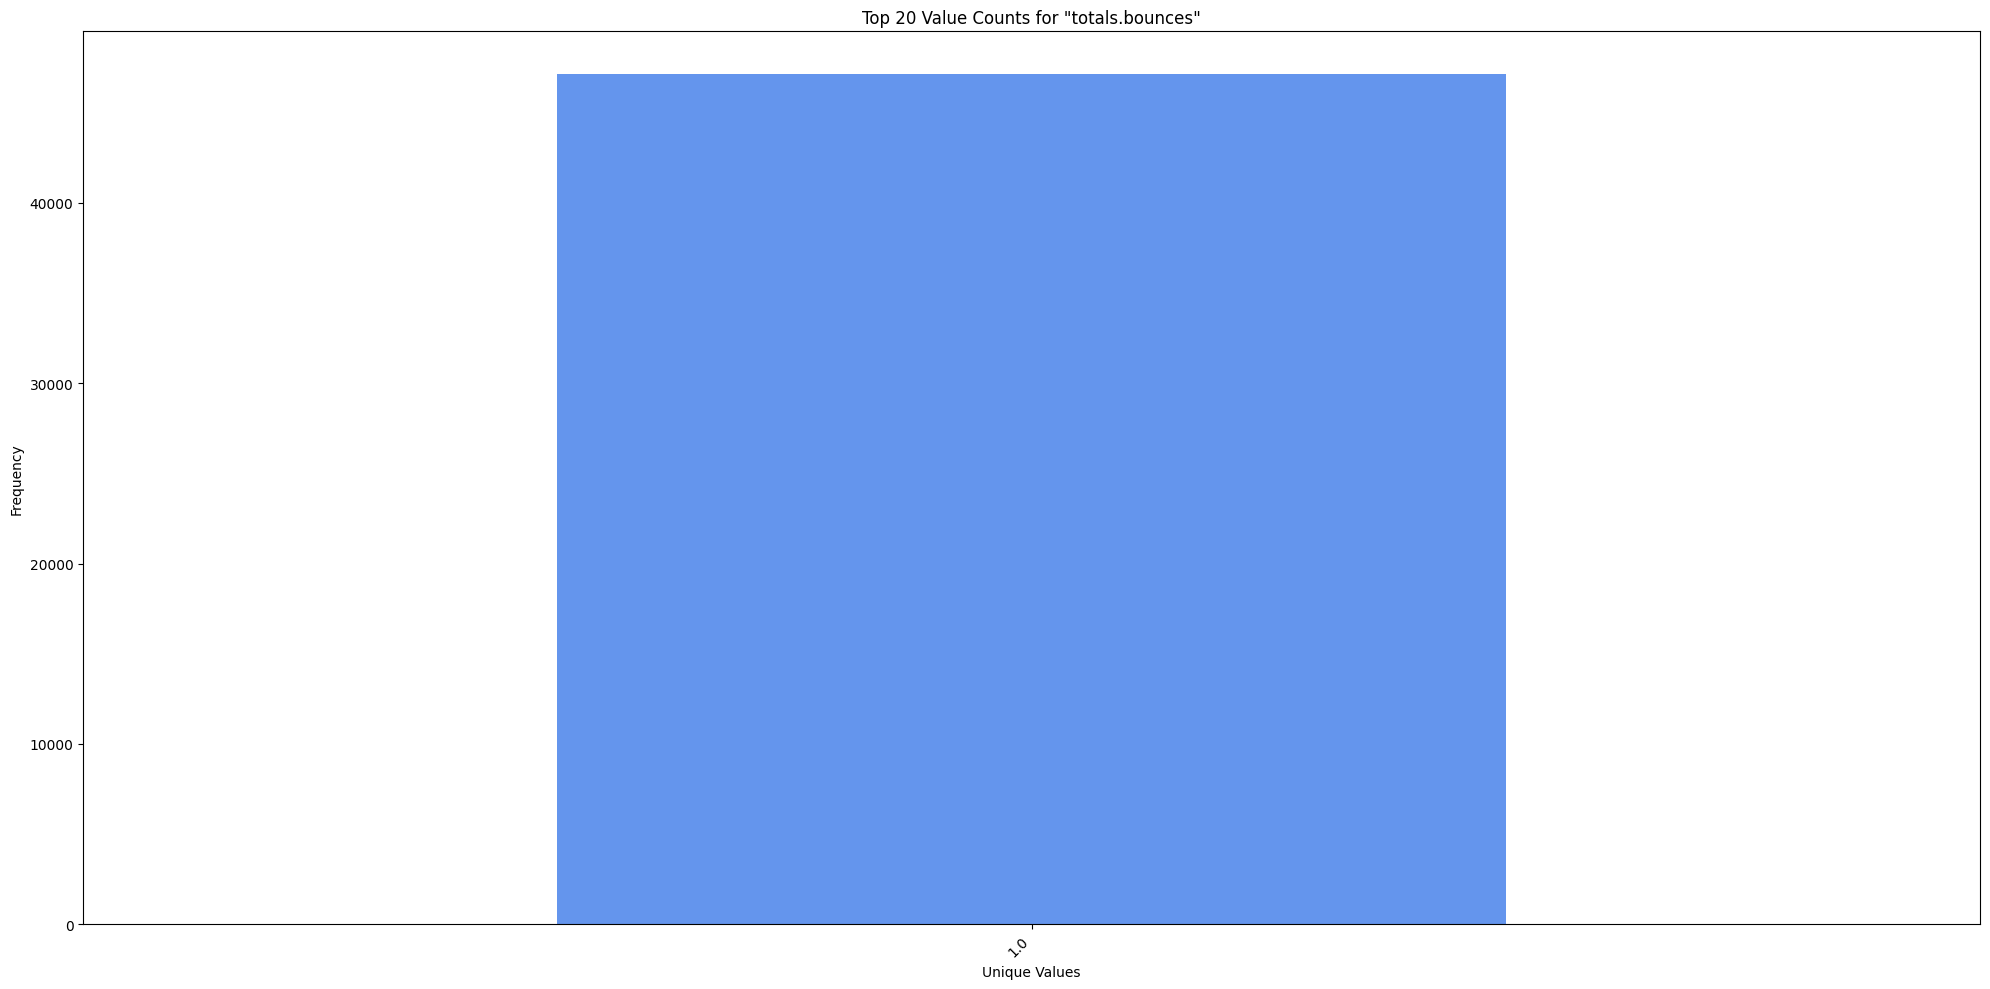

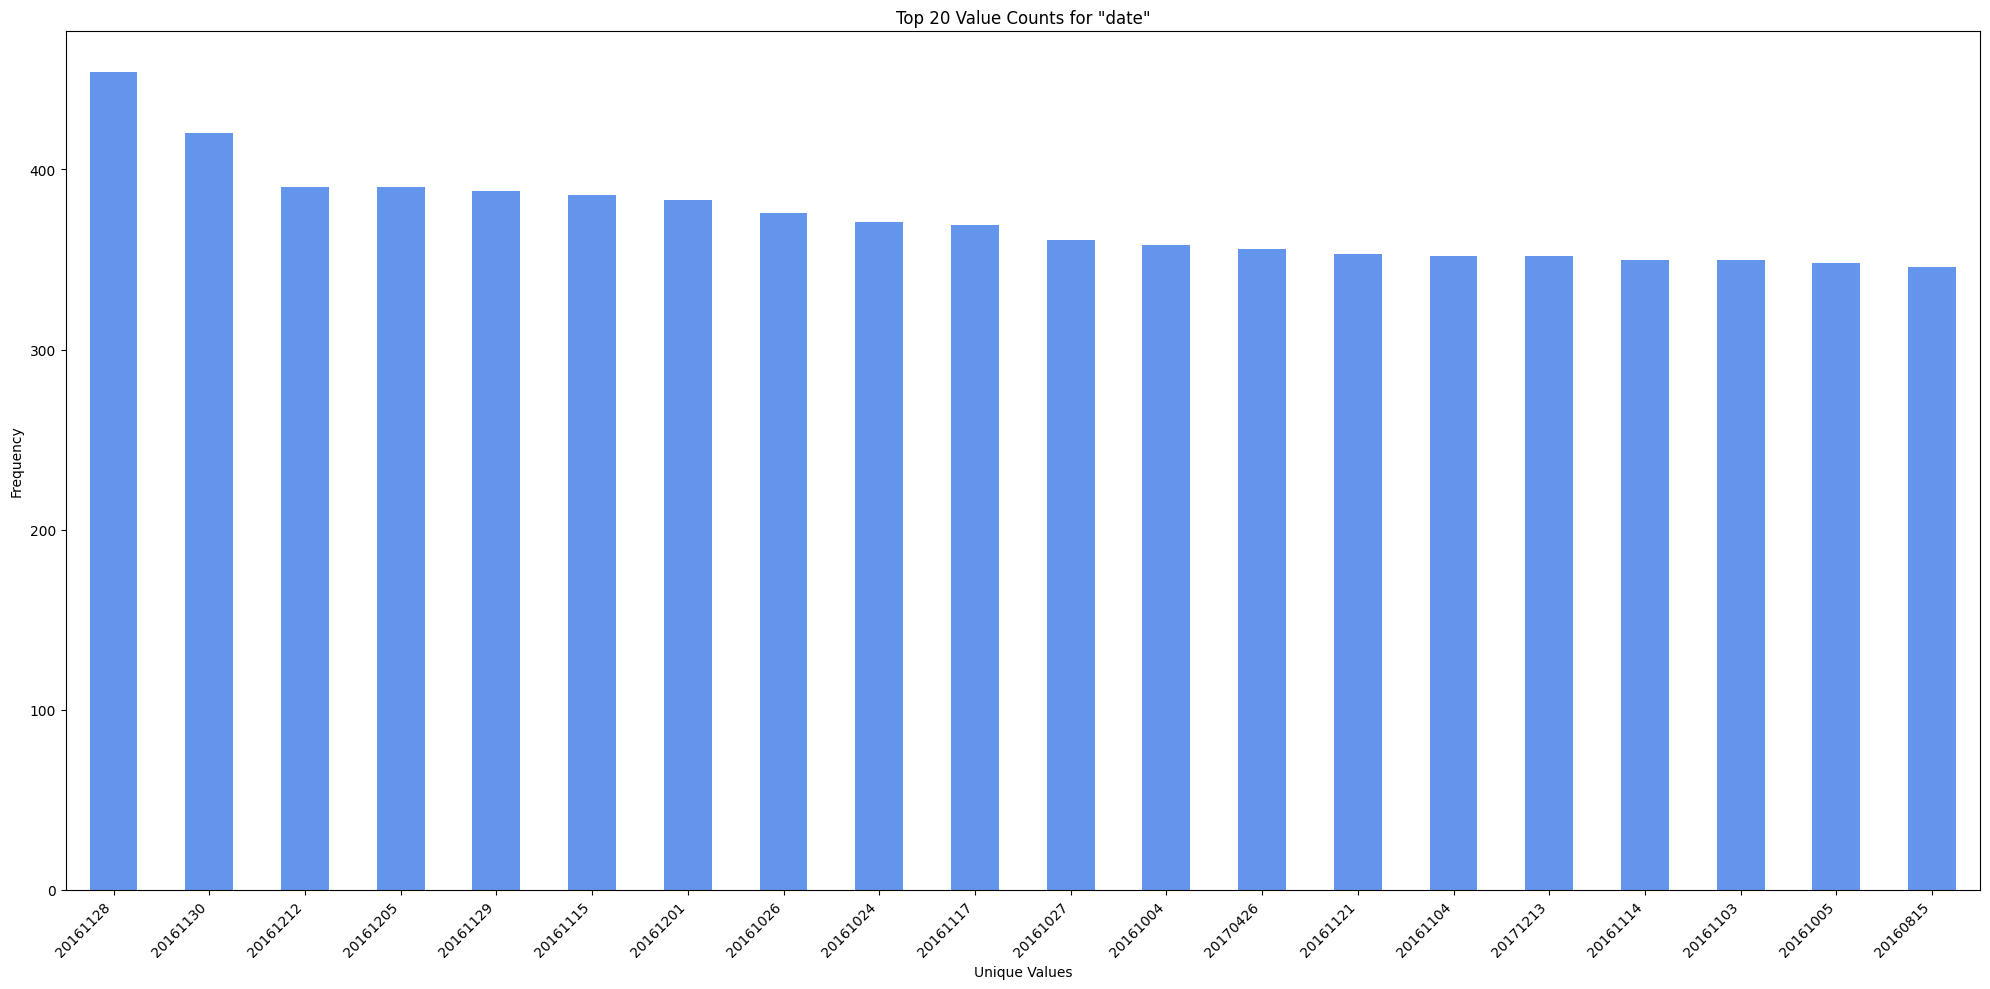

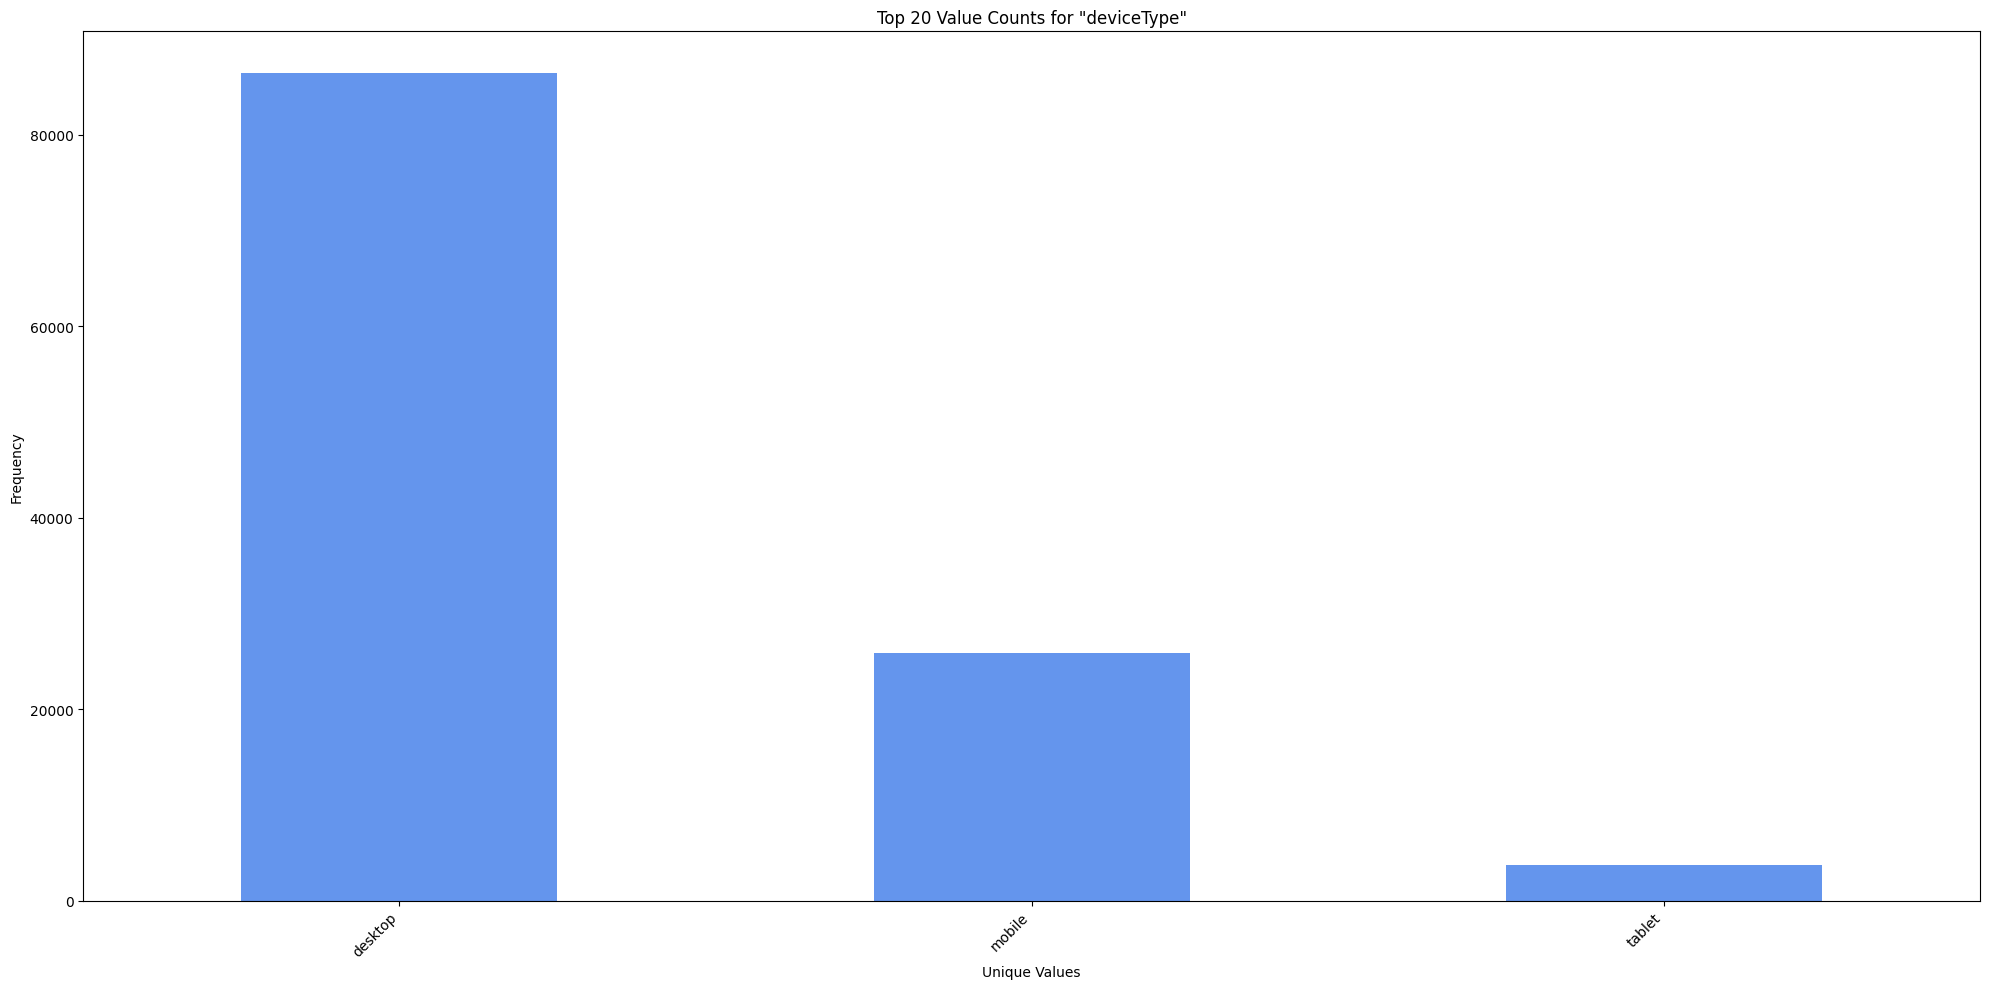

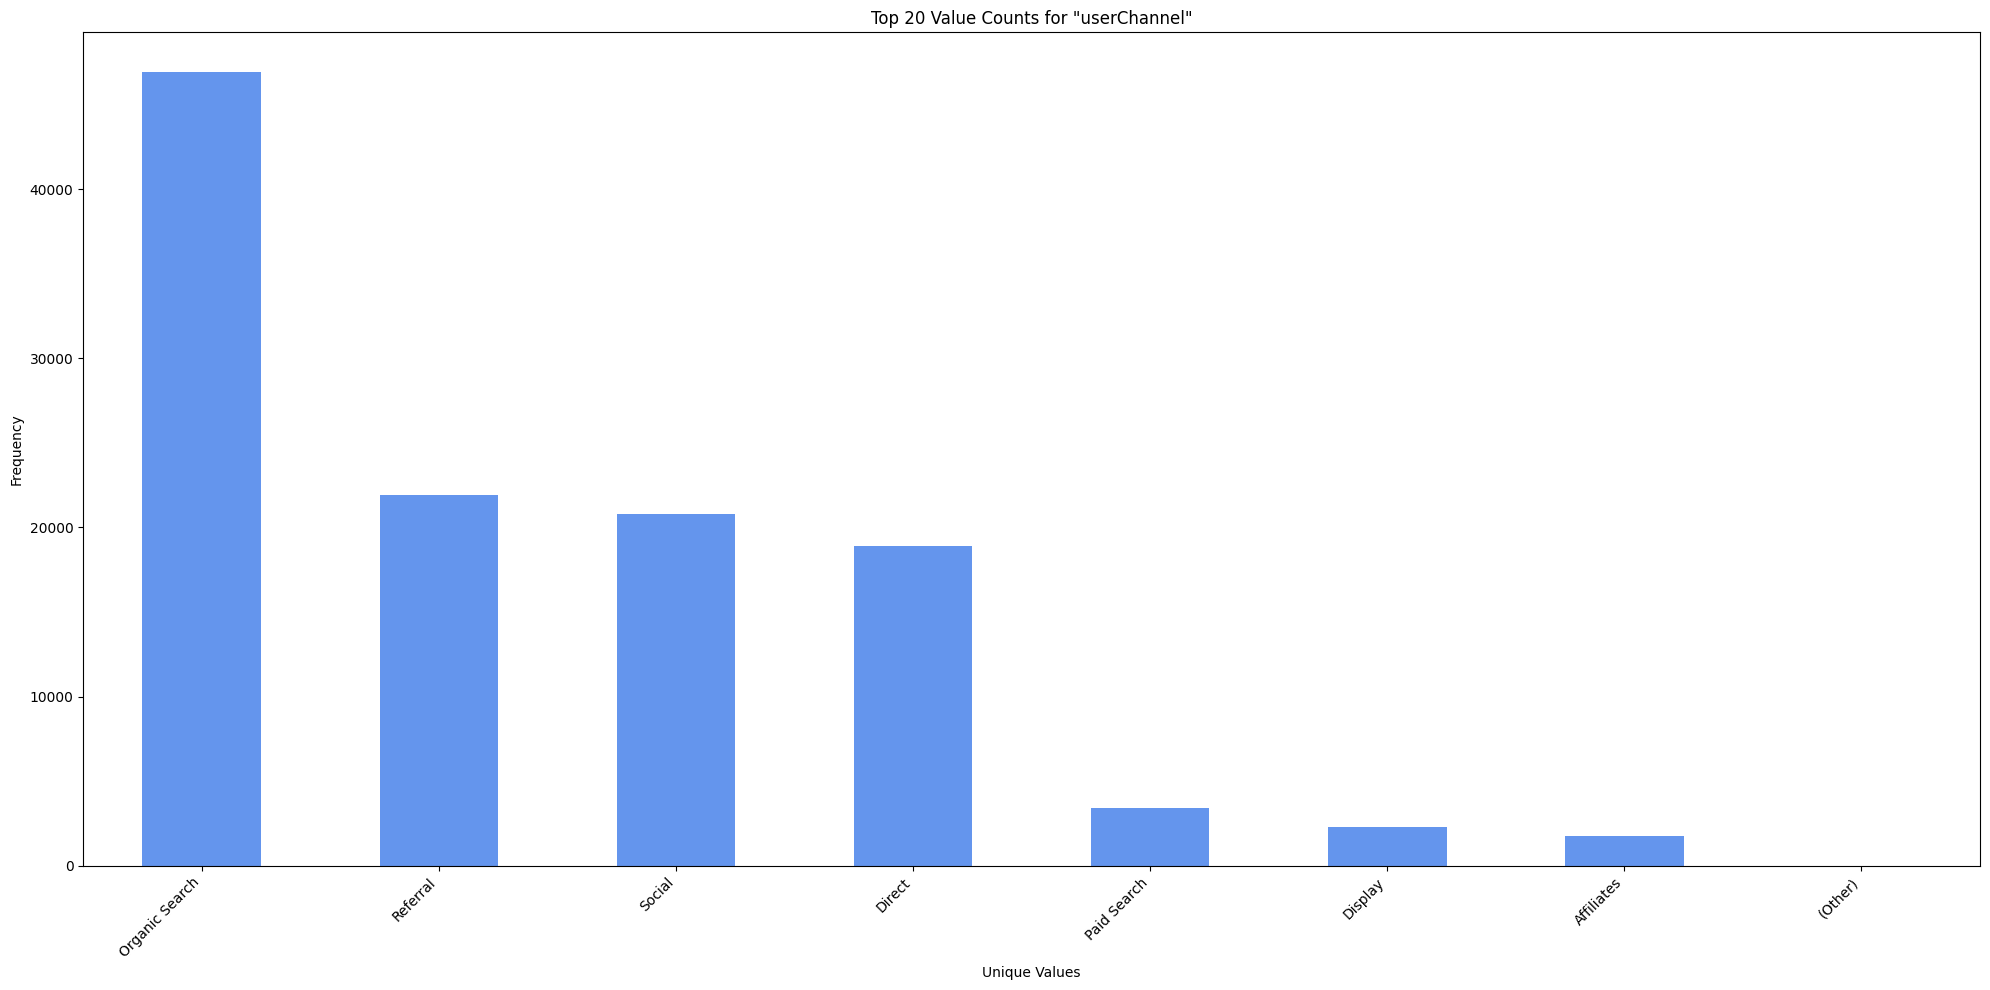

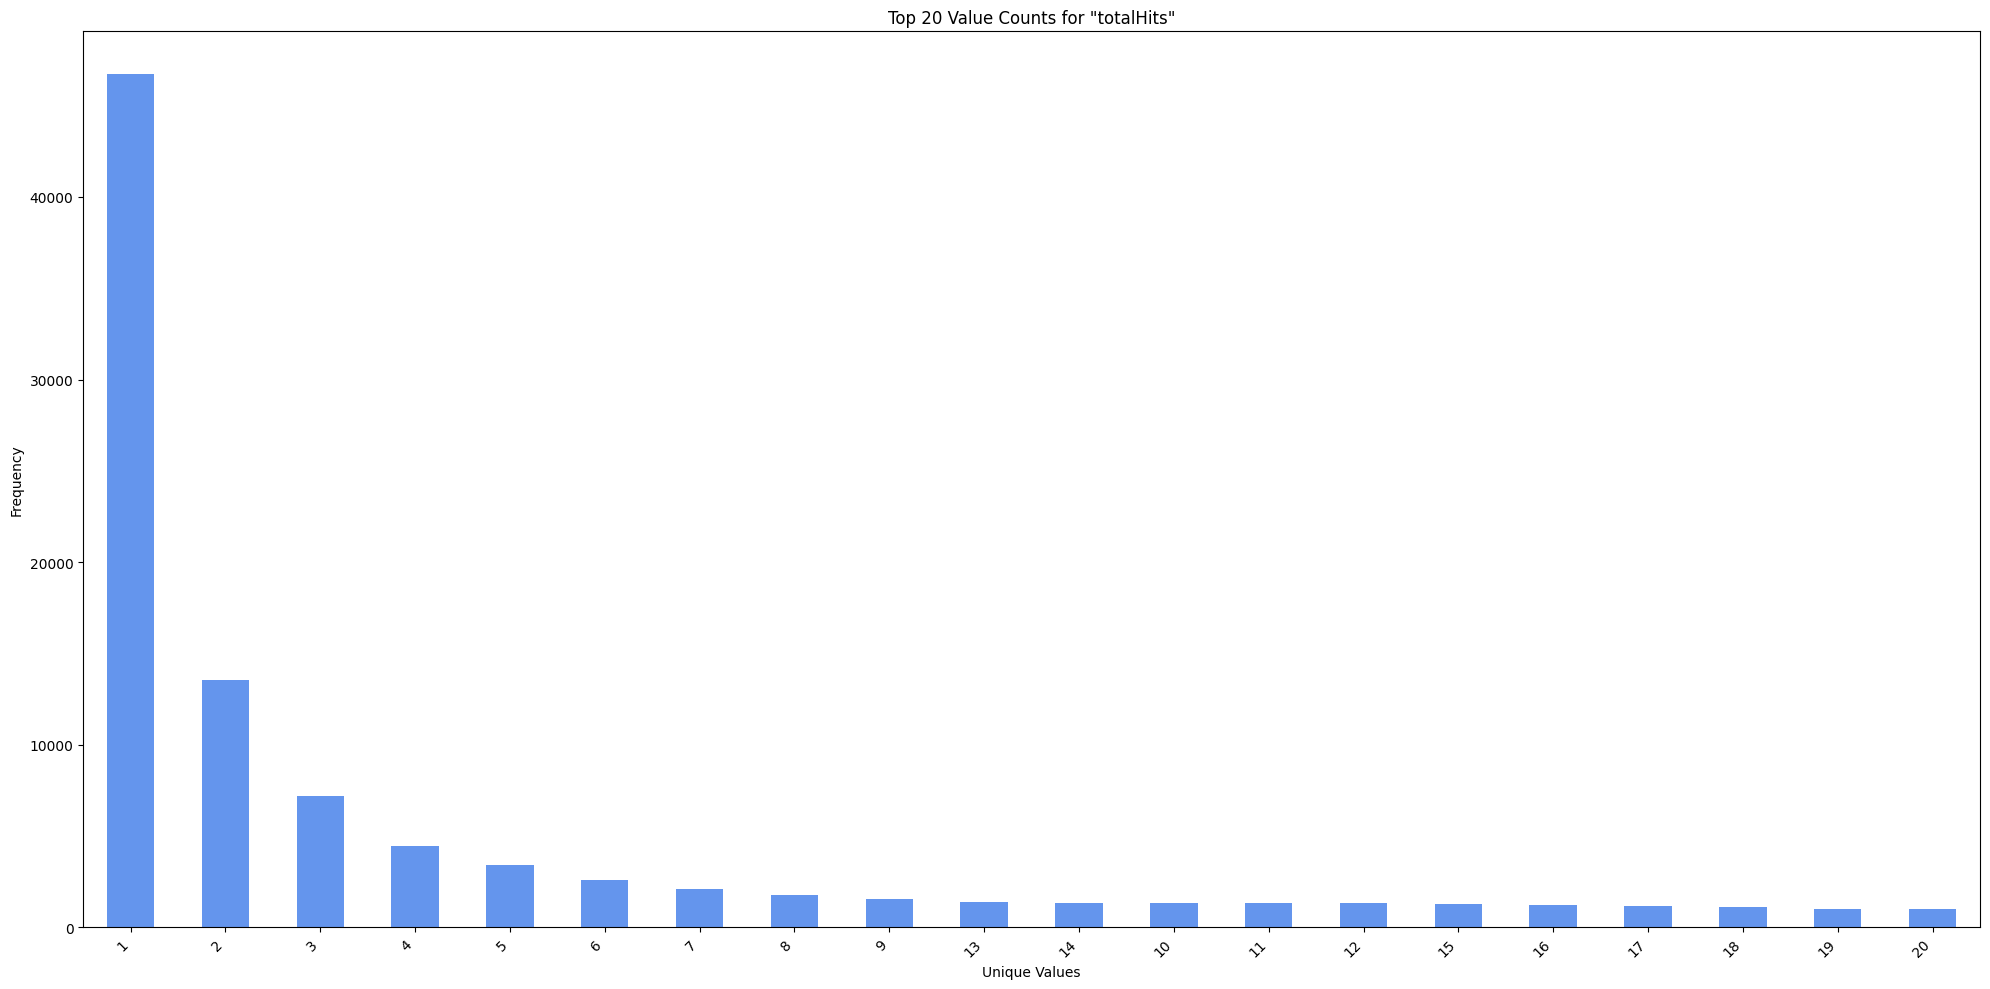

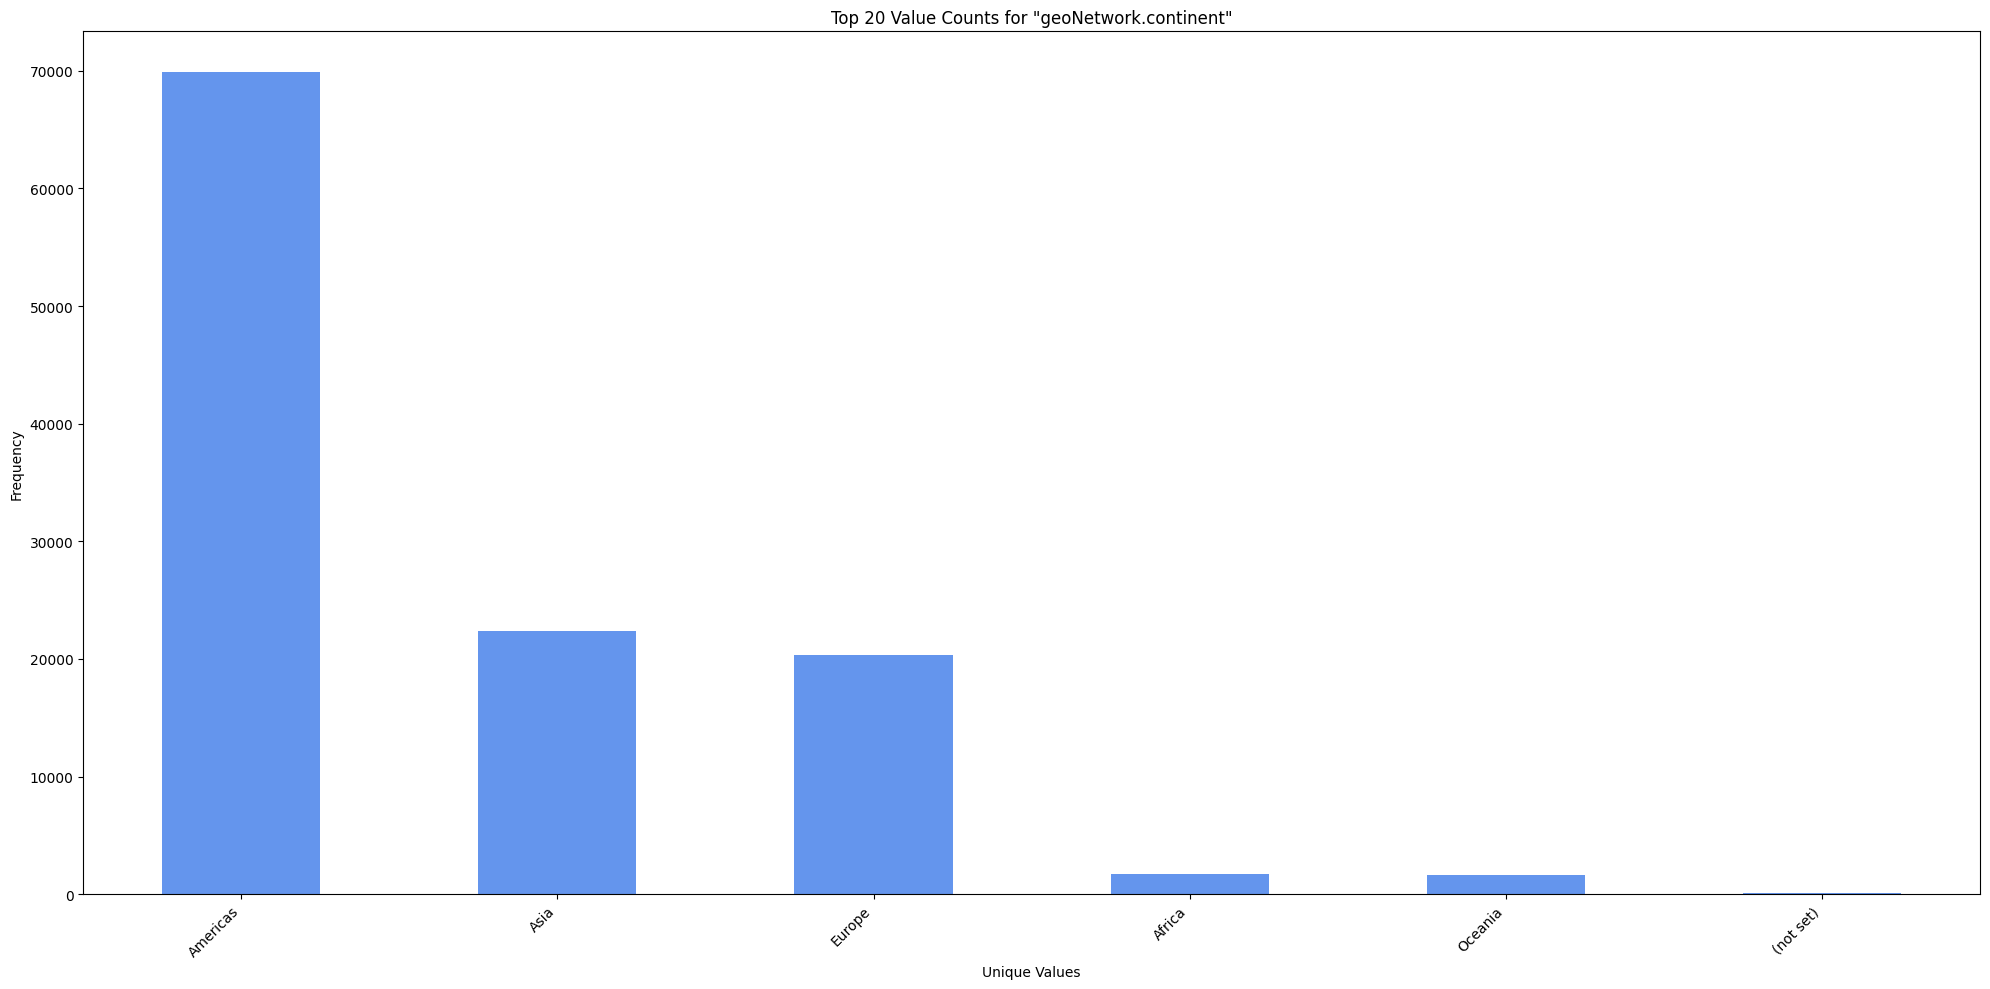

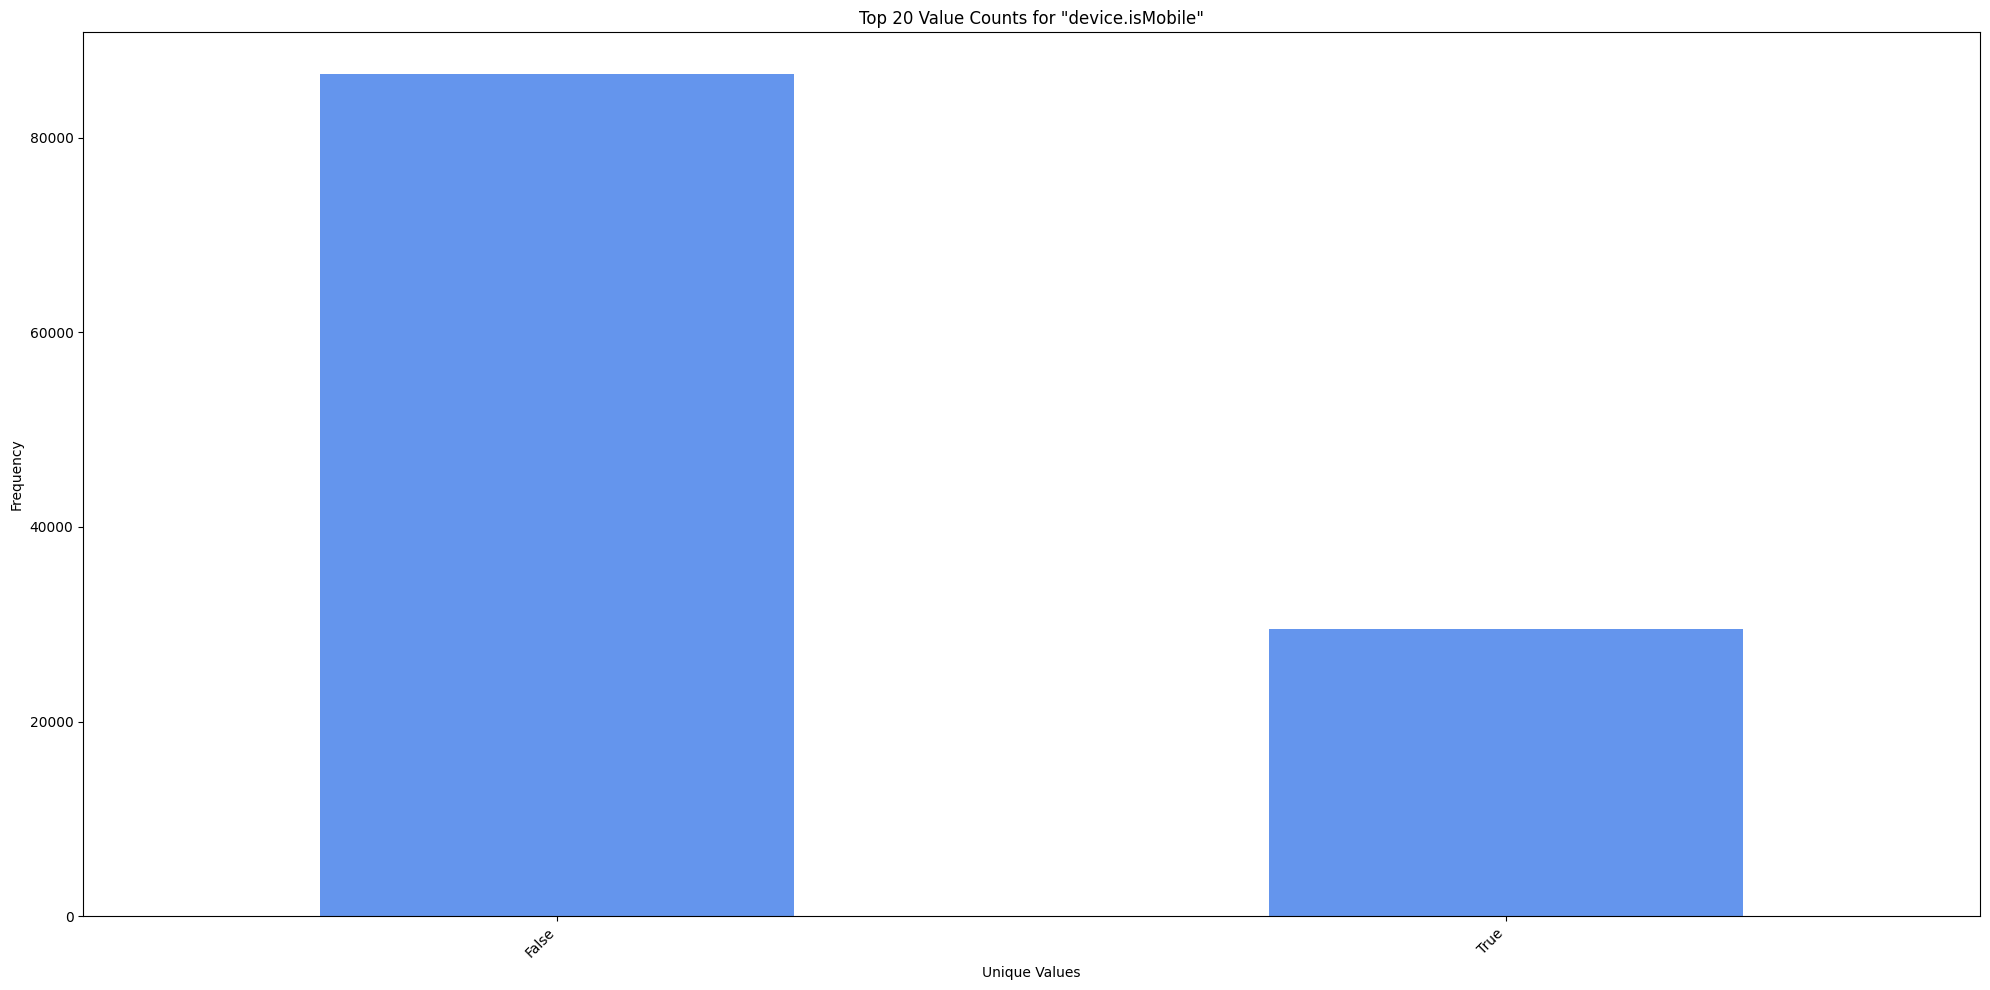

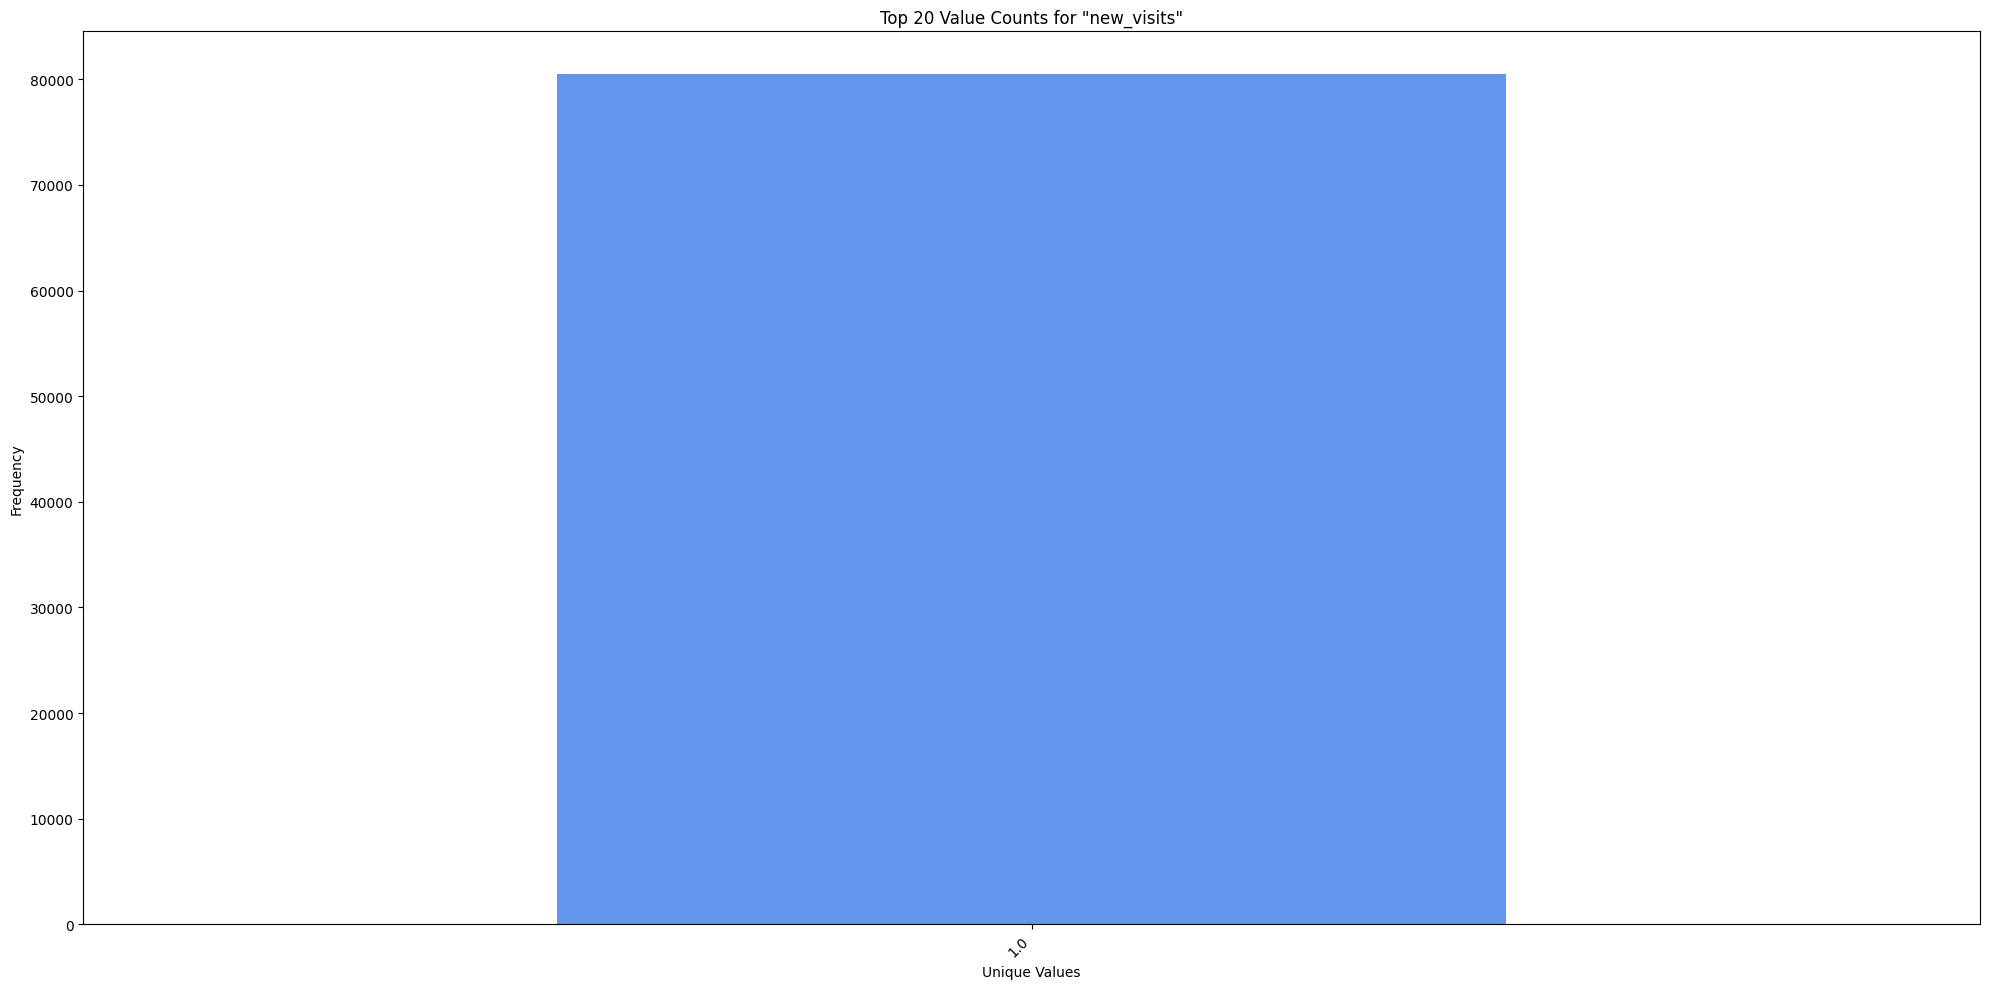

In [226]:
# Define the 17 columns
columns_to_plot = ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'trafficSource.keyword', 'geoCluster', 'trafficSource.campaign', 'geoNetwork.networkDomain', 'gclIdPresent', 'sessionNumber', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry', 'geoNetwork.city', 'geoNetwork.metro', 'pageViews', 'trafficSource.referralPath', 'totals.bounces', 'date', 'deviceType', 'userChannel', 'totalHits', 'geoNetwork.continent', 'device.isMobile', 'new_visits']

# Loop through columns and plot top 20 value counts
for col in columns_to_plot:
    plt.figure(figsize=(20, 10))
    
    try:
        vc = df_train[col].value_counts().head(20)
    except KeyError:
        print(f"Column '{col}' not found in DataFrame.")
        continue

    if vc.empty:
        print(f"[Skipped] Column '{col}' has no values.")
        continue

    vc.plot(kind='bar', color='cornflowerblue')
    plt.title(f'Top 20 Value Counts for "{col}"')
    plt.xlabel('Unique Values')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


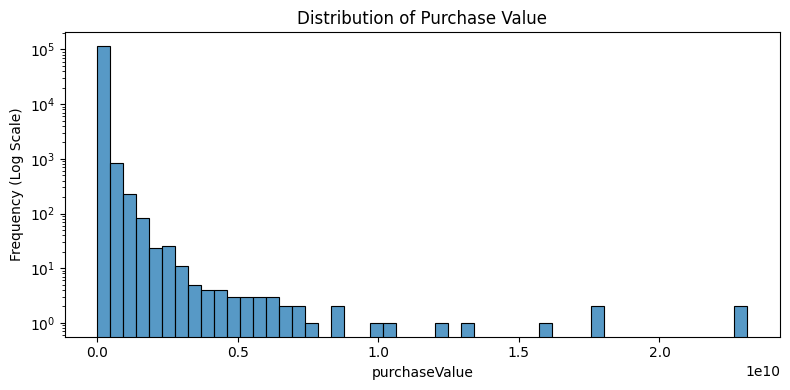

In [228]:
# Histogram of Target
plt.figure(figsize=(8, 4))
sns.histplot(df_train['purchaseValue'], bins=50, log_scale=(False, True))
plt.title('Distribution of Purchase Value')
plt.xlabel('purchaseValue')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()



 Summary Statistics for Target (purchaseValue):
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

📌 Target Mean: 26563930.083
📌 Target Median: 0.000
📌 Skew Indicator (Mean / Median): inf
📌 Zero Purchases: 92038 rows (79.3%)


/tmp/ipykernel_35/3662999995.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  skew_ratio = mean_val / median_val
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


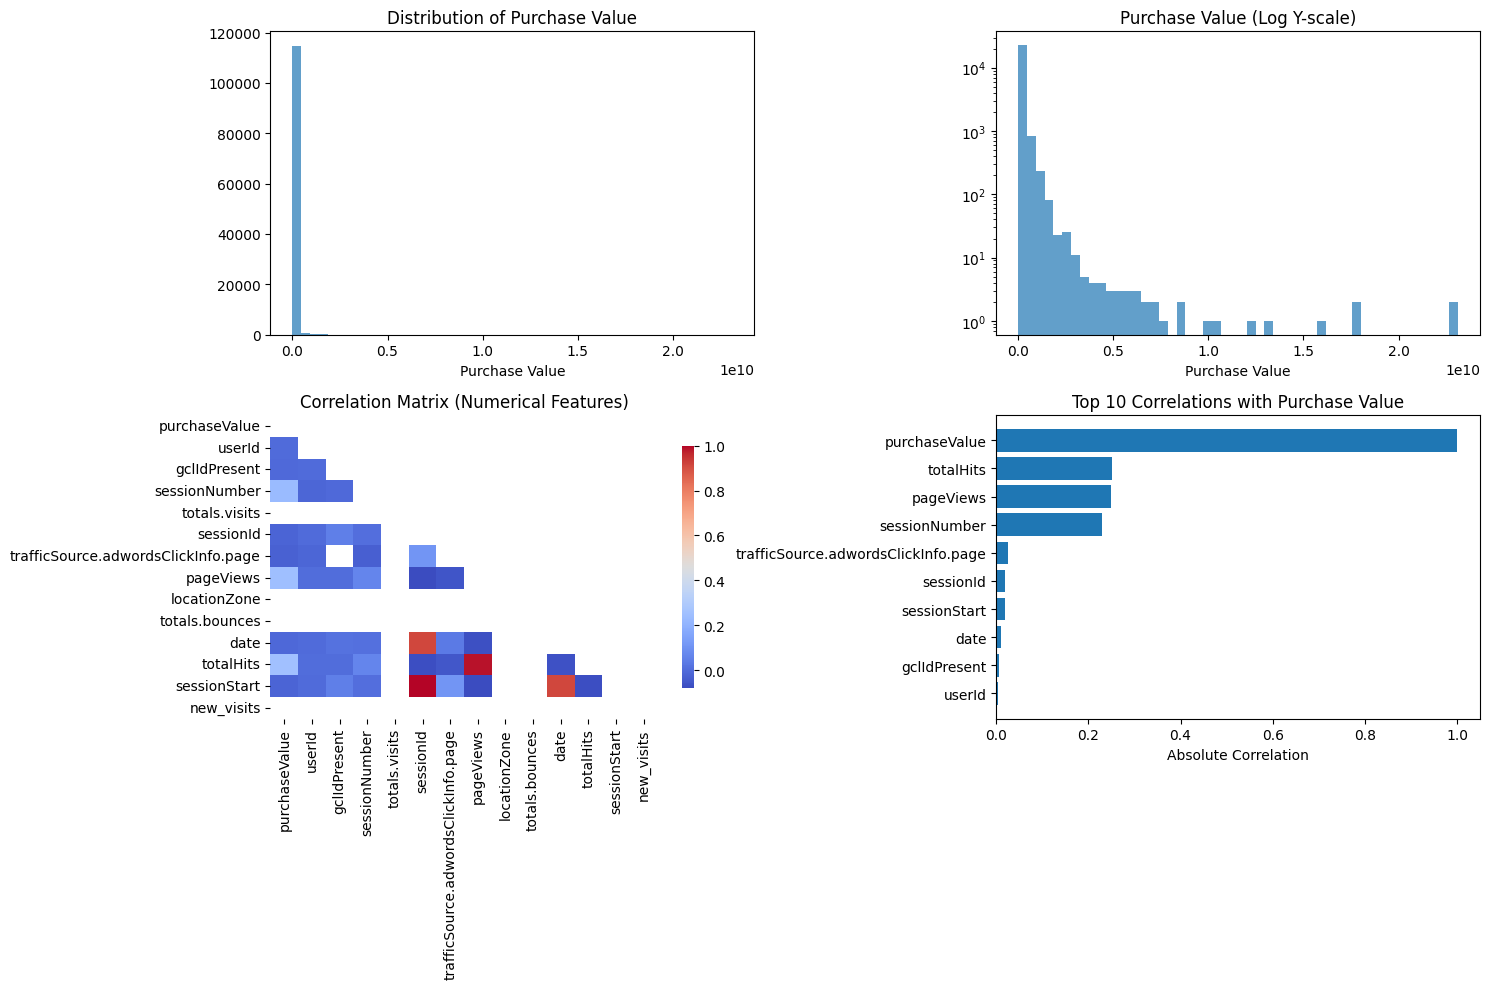

In [229]:


# -------------------------------
#  Target Variable: purchaseValue
# -------------------------------
print("\n Summary Statistics for Target (purchaseValue):")
target_stats = df_train['purchaseValue'].describe()
print(target_stats)

mean_val = target_stats['mean']
median_val = target_stats['50%']
skew_ratio = mean_val / median_val
zero_pct = (df_train['purchaseValue'] == 0).mean() * 100

print(f"\n📌 Target Mean: {mean_val:.3f}")
print(f"📌 Target Median: {median_val:.3f}")
print(f"📌 Skew Indicator (Mean / Median): {skew_ratio:.3f}")
print(f"📌 Zero Purchases: {(df_train['purchaseValue'] == 0).sum()} rows ({zero_pct:.1f}%)")

# -------------------------------
# Visualizations
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of Purchase Value
axes[0, 0].hist(df_train['purchaseValue'], bins=50, alpha=0.7)
axes[0, 0].set_title('Distribution of Purchase Value')
axes[0, 0].set_xlabel('Purchase Value')

# Log-scale Histogram (excluding zeros)
axes[0, 1].hist(df_train['purchaseValue'][df_train['purchaseValue'] > 0], bins=50, alpha=0.7)
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Purchase Value (Log Y-scale)')
axes[0, 1].set_xlabel('Purchase Value')

# -------------------------------
# Correlation Matrix
# -------------------------------
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    corr_matrix = df_train[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', ax=axes[1, 0], cbar_kws={'shrink': 0.8})
    axes[1, 0].set_title('Correlation Matrix (Numerical Features)')

# -------------------------------
# Top Features Correlated with Target
# -------------------------------
if 'purchaseValue' in df_train.columns:
    target_corr = df_train[numeric_cols].corr()['purchaseValue'].abs().sort_values(ascending=False)
    top_corr = target_corr.head(10)
    axes[1, 1].barh(range(len(top_corr)), top_corr.values)
    axes[1, 1].set_yticks(range(len(top_corr)))
    axes[1, 1].set_yticklabels(top_corr.index)
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('Top 10 Correlations with Purchase Value')
    axes[1, 1].set_xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()


Data Cleaning

In [230]:
# print(df_train.isnull().mean().sort_values(ascending=False) * 100)
# print(df_test.isnull().mean().sort_values(ascending=False) * 100)
# Features with 90% or more missing value are removed

null_thresh=0.9
merged = pd.concat([df_train, df_test], ignore_index=True)
null_ratio = merged.isnull().mean()
drop_cols = null_ratio[null_ratio > null_thresh].index.tolist()
df_train= df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [231]:
constant = [c for c in df_train.columns if df_train[c].nunique(dropna=False) == 1]
df_train = df_train.drop(columns=constant)
constant = [c for c in df_test.columns if df_test[c].nunique(dropna=False) == 1]
df_test = df_test.drop(columns=constant, errors='ignore')
# df_test

Missing Data and Simple Imputation

In [232]:
df_train.isnull().sum()
df_train['purchaseValue'].value_counts()

purchaseValue
0.0            92038
16990000.0       445
18990000.0       328
33590000.0       308
19990000.0       288
               ...  
23860000.0         1
16020000.0         1
253930000.0        1
26250000.0         1
169750000.0        1
Name: count, Length: 6766, dtype: int64

In [233]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
n_f = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_train[numerical_features] = imputer.fit_transform(df_train[numerical_features])
df_test[n_f] = imputer.fit_transform(df_test[n_f])

In [ ]:
cats = df_train.select_dtypes(include=['object']).columns
cat = df_test.select_dtypes(include=['object']).columns
df_train.select_dtypes(include=['object']).isnull().sum()
df_test.select_dtypes(include=['object']).isnull().sum()
df_train[cats] = df_train[cats].fillna('missing')
df_test[cats] = df_test[cat].fillna('missing')


**Feature Engineering

In [ ]:
user_avg = df_train.groupby('userId')['purchaseValue'].mean().rename('avgUserPurchase')
df_train = df_train.merge(user_avg, on='userId', how='left')
df_test = df_test.merge(user_avg, on='userId', how='left')
df_train['avgUserPurchase'].fillna(0)
df_test['avgUserPurchase'].fillna(0)

# Behavioral features
for dataset in [df_train, df_test]:
    dataset['views_per_hit'] = dataset['pageViews'] / dataset['totalHits']
    dataset['views_per_hit'].replace([float('inf'), -float('inf')], 0)
    dataset['views_per_hit'].fillna(0)
    dataset['newVisitorFlag'] = (dataset['avgUserPurchase'] == 0).astype(int)

In [ ]:
# Dropping unused columns 
drop_cols = ['userId', 'pageViews', 'totalHits', 'new_visits']
df_train.drop(columns=[col for col in drop_cols if col in df_train.columns], inplace=True, errors='ignore')
df_test.drop(columns=[col for col in drop_cols if col in df_test.columns], inplace=True, errors='ignore')

In [ ]:
one hot encoder fruits apple banana orange
                       001  010     100
                       1      2       3 
                       

Scaling of Numerical Feature and Encoding of Categorical Features

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Label encode
cat_features = df_train.select_dtypes(include='object').columns
for col in cat_features:
    le = LabelEncoder()
    all_vals = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
    le.fit(all_vals)
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

# Scale numeric
features_to_scale = df_train.select_dtypes(include='number').columns.difference(['purchaseValue'])
scaler = StandardScaler()
scaler.fit(pd.concat([df_train[features_to_scale], df_test[features_to_scale]]))
df_train[features_to_scale] = scaler.transform(df_train[features_to_scale])
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale]) 

In [ ]:
# Separate features and target
X_train = df_train.drop(columns='purchaseValue')
y_train = df_train['purchaseValue']

X_test = df_test.drop(columns='purchaseValue', errors='ignore') 

cat_features = X_train.select_dtypes(include='object').columns
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns



preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
    ('num', StandardScaler(), num_features)
])


# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)


Model training

In [227]:
# Best Model 0.56796

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score

X = df_train.drop(columns='purchaseValue')
y = df_train['purchaseValue']

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

search = RandomizedSearchCV(xgb, params, n_iter=15, scoring='r2', cv=3, random_state=42, verbose=1, n_jobs=-1)
search.fit(X, y)
print(f"Best R² Score: {search.best_score_:.4f}")
print("Best Parameters:", search.best_params_)
X_test = df_test[X.columns]
best_model = search.best_estimator_
best_model.fit(X, y)

preds = best_model.predict(X_test)

try:
    test_ids = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')['id']
except KeyError:
    test_ids = pd.Series(range(len(X_test_transformed)))

submission = pd.DataFrame({'id': test_ids, 'purchaseValue': preds})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")


Fitting 3 folds for each of 15 candidates, totalling 45 fits


ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
                                        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:trafficSource.isTrueDirect: object, browser: object, device.screenResolution: object, trafficSource.adContent: object, trafficSource.keyword: object, screenSize: object, geoCluster: object, trafficSource.adwordsClickInfo.slot: object, device.mobileDeviceBranding: object, device.mobileInputSelector: object, trafficSource.campaign: object, device.mobileDeviceMarketingName: object, geoNetwork.networkDomain: object, device.operatingSystemVersion: object, device.flashVersion: object, geoNetwork.region: object, trafficSource: object, geoNetwork.networkLocation: object, os: object, geoNetwork.subContinent: object, trafficSource.medium: object, trafficSource.adwordsClickInfo.isVideoAd: object, browserMajor: object, locationCountry: object, device.browserSize: object, trafficSource.adwordsClickInfo.adNetworkType: object, socialEngagementType: object, geoNetwork.city: object, geoNetwork.metro: object, device.mobileDeviceModel: object, trafficSource.referralPath: object, device.language: object, deviceType: object, userChannel: object, device.browserVersion: object, device.screenColors: object, geoNetwork.continent: object


In [ ]:
### Model Training with Two-Stage and Ensemble Approach

# We'll train two separate models:
# 1. A **classifier** to predict whether a user will make a purchase (`purchaseValue > 0`)
# 2. A **regressor** or ensemble of regressors to predict the actual `purchaseValue` when a purchase occurs

# Split target into classification and regression parts
X = df_train.drop(columns=['purchaseValue'])
y_class = (df_train['purchaseValue'] > 0).astype(int)
y_reg = df_train.loc[y_class == 1, 'purchaseValue']
X_reg = X.loc[y_class == 1]

# -----------------------------
# 1. Classifier: GradientBoostingClassifier
# -----------------------------
clf = GradientBoostingClassifier(random_state=42)
clf_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

clf_search = RandomizedSearchCV(
    clf,
    param_distributions=clf_param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
clf_search.fit(X, y_class)
print(f"Best classifier F1 score: {clf_search.best_score_:.4f}")
print(f"Best classifier params: {clf_search.best_params_}")

# -----------------------------
# 2. Ensemble Regressor
# -----------------------------
models = {
    'xgb': XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'lgb': LGBMRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'rf': RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

# Cross-validation and training
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model_scores = {}

print("\nModel Cross-Validation Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_reg, y_reg, cv=kfold, scoring='r2', n_jobs=-1)
    model_scores[name] = scores
    print(f"{name.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

trained_models = {}
for name, model in models.items():
    model.fit(X_reg, y_reg)
    trained_models[name] = model

def ensemble_predict(df_test):
    predictions = []
    for model in trained_models.values():
        predictions.append(model.predict(df_test))
    return np.mean(predictions, axis=0)


In [ ]:
# LGMRegression 
X = df_train.drop(columns='purchaseValue')
y = df_train['purchaseValue']

model = LGBMRegressor(objective='regression', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

search = RandomizedSearchCV(
    model, param_distributions=param_dist,
    scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_iter=25, verbose=1, n_jobs=-1
)
search.fit(X, y)

print("Best Params:", search.best_params_)
lgbm_model = search.best_estimator_
preds = lgbm_model.predict(X)
r2 = r2_score(y, preds)
rmse = mean_squared_error(y, preds, squared=False)
print(f"Validation R² Score: {r2:.4f}")
print(f"Validation RMSE: {rmse:.2f}")
preds = model.predict(df_test)
submission = pd.DataFrame({'id': range(len(preds)), 'purchaseValue': preds})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as lgbm_submission.csv")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Initialize model
model = RandomForestRegressor(random_state=42)

# Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
search = RandomizedSearchCV(
    model, param_distributions=param_dist,
    scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_iter=25, verbose=1, n_jobs=-1
)

# Fit search
search.fit(X_reg, y_reg)

# Best model
print("Best Params:", search.best_params_)
rf_model = search.best_estimator_

# Evaluate on training/validation set
preds = rf_model.predict(X)
r2 = r2_score(y, preds)

print(f"Validation R² Score: {r2:.4f}")


# Predict on test set
preds = rf_model.predict(X_test)
submission = pd.DataFrame({'id': range(len(preds)), 'purchaseValue': preds})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as rf_submission.csv")


In [ ]:
### Model Training with Two-Stage Approach 0.36684

# We'll train two separate models:
# 1. A **classifier** to predict whether a user will make a purchase (`purchaseValue > 0`)
# 2. A **regressor** to predict the actual `purchaseValue` for the cases where purchase happens
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Split target into classification and regression parts
X = df_train.drop(columns=['purchaseValue'])
y_class = (df_train['purchaseValue'] > 0).astype(int)
y_reg = df_train.loc[y_class == 1, 'purchaseValue']

# -----------------------------
# 1. Classifier: GradientBoostingClassifier
# -----------------------------
clf = GradientBoostingClassifier(random_state=42)
clf_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

clf_search = RandomizedSearchCV(
    clf,
    param_distributions=clf_param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
clf_search.fit(X, y_class)
print(f"Best classifier F1 score: {clf_search.best_score_:.4f}")
print(f"Best classifier params: {clf_search.best_params_}")

# -----------------------------
# 2. Regressor: XGBRegressor
# -----------------------------
X_reg = X.loc[y_class == 1]

reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
reg_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

reg_search = RandomizedSearchCV(
    reg,
    param_distributions=reg_param_dist,
    n_iter=15,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
reg_search.fit(X_reg, y_reg)
print(f"Best regressor R² score: {reg_search.best_score_:.4f}")
print(f"Best regressor params: {reg_search.best_params_}")
# Inference on Test Data
# -----------------------------
# Prepare test features
X_test = df_test[X.columns].dropna()

# Predict purchase probability (classifier)
y_test_class_pred = clf_search.predict(X_test)

# Predict purchase value only for predicted positive class
X_test_positive = X_test[y_test_class_pred == 1]
y_test_value_pred = reg_search.predict(X_test_positive)

# Initialize final prediction array
final_predictions = [0] * len(X_test)

# Fill in predicted purchase values
pos_indices = X_test_positive.index
for idx, pred in zip(pos_indices, y_test_value_pred):
    final_predictions[idx] = pred

# Save predictions
submission_df = pd.DataFrame({
    'id': test_ids,
    'purchaseValue': final_predictions
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved: submission.csv")


Milestone 1

In [ ]:
df1 = df[df['totals.bounces'] == 0]
df1['pageViews'].corr(df1['purchaseValue'])


In [ ]:
df.groupby('geoNetwork.continent')['totalHits'].mean()

In [ ]:
df1 = df[df['purchaseValue'] > 0].copy()
#df1['trafficSource.medium'].value_counts()

#df1['osbrowser'] = df1['os'] + '-' + df1['browser']


#df1['trafficSource.referralPath'].value_counts()

#df1.groupby('os')['purchaseValue'].mean()
#df1.groupby('userId')['sessionId'].nunique().mean()
#df1['userId'].nunique()


In [ ]:
df.groupby('os')['purchaseValue'].mean().idxmax()


In [ ]:
df['trafficSource.medium'].value_counts()
df['trafficSource.medium'].shape

In [ ]:
print(40654/116023)

In [ ]:
#df.groupby('userId')['sessionId'].nunique().mean()

In [ ]:
#df['userId'].nunique()

In [ ]:
df2 = df[df['purchaseValue']==0]
df3 = df[df['purchaseValue']>0]
df3['totalHits'].mean()/df2['totalHits'].mean()

In [ ]:
df['trafficSource.isTrueDirect'].value_counts()
df['trafficSource.isTrueDirect'] = df['trafficSource.isTrueDirect'].fillna(False).astype(bool)
df['trafficSource.isTrueDirect'].isnull().sum()

In [ ]:
df['trafficSource.keyword'].value_counts()
df['trafficSource.keyword'] = df['trafficSource.keyword'].fillna('(not provided)')
df['trafficSource.keyword'].isnull().sum()

In [ ]:
df.shape

In [ ]:
#df['pageViews']

*MILESTONE 2*


When visualizing the distribution of totalHits across the dataset, which of the following would be most accurate?
*
The distribution is normally distributed
The distribution is right-skewed with most sessions having fewer than 10 hits
The distribution is left-skewed with most sessions having more than 20 hits
The distribution is uniform across all possible values

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'totalHits' is a column in your DataFrame (df)
# Replace this with your actual DataFrame if it's not already loaded.

# Plotting a Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['totalHits'], kde=False, bins=10, color='blue')
plt.title('Distribution of Total Hits', fontsize=16)
plt.xlabel('Total Hits', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Optional: Box Plot for Outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['totalHits'], color='orange')
plt.title('Box Plot of Total Hits', fontsize=16)
plt.xlabel('Total Hits', fontsize=12)
plt.show()



A data scientist created a model to predict purchases using a 70-30 stratified train-validation split. If the validation set contains 20.68% of records with purchases and there were 23,985 purchase records in total, approximately how many purchase records were in the training set?


In [ ]:
total_purchase_records = 23985
train_ratio = 0.7
train_purchase_records = train_ratio * total_purchase_records
train_purchase_records = round(train_purchase_records)
print(train_purchase_records )


What is the correlation coefficient between pageViews and purchaseValue for mobile users only?


In [ ]:
df1 = df[df['deviceType' ]== 'mobile']
print(df['pageViews'].corr(df['purchaseValue']))
print(np.corrcoef(df['pageViews'],df['purchaseValue']))


When normalizing the purchase value column, what would be the approximate standard deviation of the normalized values?


In [ ]:
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_values = scaler.fit_transform(df['purchaseValue'])
print(f"Std Dev: {normalized_values.std():.2f}")'''
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df has a column 'purchaseValue'
scaler = StandardScaler()
df['purchaseValue_normalized'] = scaler.fit_transform(df[['purchaseValue']])  

print(df['purchaseValue_normalized'].std())  



If we build a linear regression model to predict purchase value using totalHits and pageViews as features, which coefficient would likely have a larger magnitude?
*
totalHits coefficient
pageViews coefficient
Both would have equal magnitudes
It cannot be determined from the available information


In [ ]:
df[['totalHits', 'pageViews', 'purchaseValue']].corr()['purchaseValue']
from sklearn.linear_model import LinearRegression

# Features (X) and target (y)
X = df[['totalHits', 'pageViews']]
y = df['purchaseValue']

# Fit model
model = LinearRegression()
model.fit(X, y)

# Coefficients
print(f"totalHits coefficient: {model.coef_[0]:.4f}")
print(f"pageViews coefficient: {model.coef_[1]:.4f}")
from sklearn.preprocessing import StandardScaler

# Standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Refit model
model_scaled = LinearRegression()
model_scaled.fit(X_scaled, y)

# Scaled coefficients
print(f"Scaled totalHits coefficient: {model_scaled.coef_[0]:.4f}")
print(f"Scaled pageViews coefficient: {model_scaled.coef_[1]:.4f}")


What percentage of the dataset has missing values in the totals.bounces column?


In [ ]:
missing_bounces = df['totals.bounces'].isna().sum()
total_rows = len(df)
print((missing_bounces / total_rows) * 100)


**Milestone3**

Preprocessing Pipeline
The preprocessing steps mentioned below are to be used for all the questions that are a part of this milestone.

Impute the categorical columns with the mode and the numerical columns with the mean.
Perform One Hot Encoding on all the categorical columns. Use a standard scaler to scale all the numerical columns, perform a train test split with a test size 0.2 and random state = 42.


Model 1
Fit a RandomForestRegressor model (random state = 42) on the training set and perform hyper parameter tuning using grid search with 3 folds and use scoring as r2, using the following values:

1. max_depth: [20, 30]
2. min_samples_split: [2, 5]
3. n_estimators: [50, 100]


In [ ]:
'''from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df.drop(columns = ['purchaseValue'])
y = df['purchaseValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)'''

Model 1
Fit a RandomForestRegressor model (random state = 42) on the training set and perform hyper parameter tuning using grid search with 3 folds and use scoring as r2, using the following values:

1. max_depth: [20, 30]
2. min_samples_split: [2, 5]
3. n_estimators: [50, 100]

In [ ]:
'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfg = RandomForestRegressor(random_state =42)
param = {
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100]
}
gs = GridSearchCV(
    estimator = rfg,
    param_grid = param,
    cv =3,
    scoring ='r2',
    verbose=1,
    n_jobs=-1 
)

gs.fit(X_train, y_train)
'''

What is the best value of n_estimators?
What is the best value of max_depth?
What is the best value of min_samples_split?

In [ ]:
#print(gs.best_params_)

Use the best estimator obtained from the previous question and compute the R2 score on the validation set (as obtained in the train test split done earlier). Enter the score correct up to 2 decimal points.
If the answer you are getting 0.452974123 then put 0.45

In [ ]:
#y_pred = gs.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
#print(r2_score(y_test,y_pred))

In [ ]:
'''submission = pd.DataFrame({
    #'ID': X_test.index,      # Using the DataFrame index as Id
    'id' : range(len(y_pred)),
    'purchaseValue': y_pred
})

submission.to_csv('/kaggle/working/submission.csv', index=False)'''

Model 2
Fit an AdaBoostRegressor model (random state = 42) on the training set and perform hyper parameter tuning using grid search with 3 folds and use scoring as accuracy, using the following values :

1. n_estimators: [10, 20, 30]

2. learning_rate: [3, 9]


In [ ]:
'''from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
ada = AdaBoostRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [3, 9]
}
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1 
)
grid_search.fit(X_train, y_train)'''

What is the best number of estimators from your grid search?
What is the best value for learning rate?


In [ ]:
#print(grid_search.best_estimator_)

In [ ]:
'''best_ada = grid_search.best_estimator_

# Calculate R² score on the test set (validation set)
test_r2 = best_ada.score(X_test, y_test)

# Round to 2 decimal places
final_r2 = round(test_r2, 2)
y_pred = grid_search.predict(X_test)

print(f"Validation R² Score: {final_r2}")
'''

In [ ]:
'''submission = pd.DataFrame({
    #'ID': X_test.index,      # Using the DataFrame index as Id
    'id' : range(len(y_pred)),
    'purchaseValue': y_pred
})'''

'''submission.to_csv('/kaggle/working/submission.csv', index=False)'''

In [ ]:
'''df.drop(columns=['userId', 'sessionId'], inplace=True)
df = df.drop(columns=['trafficSource.isTrueDirect' , 'trafficSource.referralPath' , 'trafficSource.keyword' , 'trafficSource.referralPath','trafficSource.adwordsClickInfo.slot' , 'trafficSource.adwordsClickInfo.isVideoAd' , 'trafficSource.adwordsClickInfo.adNetworkType' , 'trafficSource.adwordsClickInfo.page' , 'trafficSource.adContent' ])
singular_cols = [col for col in df.columns if df[col].nunique(dropna=False) == 1] 
print(singular_cols) 
df = df.drop(columns=singular_cols)'''

In [ ]:
df.shape

In [ ]:
print(df.columns.tolist())

Try hyperparameter tuning for 2 more models and describe your approach and understanding of the results obtained

In [ ]:
#submission.to_csv('submission.csv', index=False)

In [ ]:
import os
print(os.listdir('/kaggle/working'))

In [ ]:
'''from xgboost import XGBRegressor
from sklearn.metrics import r2_score

param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_xgb = RandomizedSearchCV(xgb, param_grid, n_iter=10, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
y_pred = grid_xgb.predict(X_test)
print(r2_score(y_test, y_pred))
'''

In [ ]:
'''
submission = pd.DataFrame({
    #'ID': X_test.index,      # Using the DataFrame index as Id
    'id' : range(len(y_pred)),
    'purchaseValue': y_pred
})

submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.to_csv('submission.csv', index=False)
'''

In [ ]:
'''
import os
print(os.listdir('/kaggle/working'))
'''

Milestone 4

Preprocessing steps:

Separate the training set into (X) and (Y) matrices

Use train_test_split with test_size=0.2 and random_state=39

Transform categorical variables by imputing with mode, then using OneHotEncoder. 

Transform numerical variables by imputing with mean then scale with Standard scalar

Round off the values to the nearest 3 digits 


22f3000980@ds.study.iitm.ac.in Switch account
 
* Indicates required question
Email
*
Record 22f3000980@ds.study.iitm.ac.in as the email to be included with my response
Instructions for questions 1-3
For the next three questions, fit the training data into MLPRegressor with hidden_layer=(5,3)
1. What is the training score?
2. What is the test score?



In [ ]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score

# Separate features and target
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Define column types
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Round off
X_train_transformed = np.round(X_train_transformed, 3)
X_test_transformed = np.round(X_test_transformed, 3)
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(5, 3), random_state=39, max_iter=1000)
mlp.fit(X_train_transformed, y_train)

train_score = mlp.score(X_train_transformed, y_train)
test_score = mlp.score(X_test_transformed, y_test)

print("Q1. Train score:", train_score)
print("Q2. Test score:", test_score)'''



Instructions for questions 4-6
For the following steps, use a VotingRegressor composed of:

A Linear Regression

A Gradient Boosting Regressor (random_state=39)


4.  What is the test score?
*
5.  What is the train score?


In [ ]:
'''lin = LinearRegression()
gbr = GradientBoostingRegressor(random_state=39)

voting1 = VotingRegressor([('lr', lin), ('gbr', gbr)])
voting1.fit(X_train_transformed, y_train)

test_score_1 = voting1.score(X_test_transformed, y_test)
train_score_1 = voting1.score(X_train_transformed, y_train)

print("Q4. Test score (Linear + GBR):", test_score_1)
print("Q5. Train score (Linear + GBR):", train_score_1)'''


Repeat the same, with replacing the linear regressor with a ridge regressor with random_state=39, decide the better estimator based on the score, and explain your process in solving this.

In [ ]:
'''from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

# Model 1: Linear Regression + Gradient Boosting
lr = LinearRegression()
gbr = GradientBoostingRegressor(random_state=39)

voting1 = VotingRegressor([('lr', lr), ('gbr', gbr)])
voting1.fit(X_train_transformed, y_train)

test_score_1 = voting1.score(X_test_transformed, y_test)
train_score_1 = voting1.score(X_train_transformed, y_train)

print("Model 1: LinearRegression + GradientBoosting")
print("Train Score:", train_score_1)
print("Test Score:", test_score_1)

# Model 2: Ridge Regression + Gradient Boosting
ridge = Ridge(random_state=39)
voting2 = VotingRegressor([('ridge', ridge), ('gbr', gbr)])
voting2.fit(X_train_transformed, y_train)

test_score_2 = voting2.score(X_test_transformed, y_test)
train_score_2 = voting2.score(X_train_transformed, y_train)

print("\nModel 2: Ridge + GradientBoosting")
print("Train Score:", train_score_2)
print("Test Score:", test_score_2)

# Compare which model is better based on test score
if test_score_2 > test_score_1:
    better_model = "Ridge + GBR"
else:
    better_model = "Linear + GBR"

print(f"\nQ6 Final Result: The better estimator based on test score is: {better_model}")'''


MileStone 5

Part 1: Initial Data Cleaning
Task: Clean and encode data using these rules:


Drop columns with >70% missing values

Drop high cardinality ID columns (userId, sessionId.)
Impute the NaN values of purchaseValue as 0.


In [ ]:
df = df.drop(columns=['trafficSource.adwordsClickInfo.slot' , 'trafficSource.adwordsClickInfo.isVideoAd' , 'trafficSource.adwordsClickInfo.adNetworkType' , 'trafficSource.adwordsClickInfo.page' , 'trafficSource.adContent' ])
#df.drop(columns=['userId', 'sessionId'], inplace=True)

In [ ]:
from sklearn.pipeline import Pipeline
cat = df_train.select_dtypes(include=['object']).columns
num = df_train.select_dtypes(include=['int', 'float64']).columns
scaler = StandardScaler()
imputer = SimpleImputer()
encoder = OrdinalEncoder()
cat_cols = Pipeline([
    ('enc',encoder, cat),
    
])
num_cols = Pipeline(
    [
        ('imp', imputer, num),
        ('ss', scaler, num)
    ]
)
print(cat_cols)